# State of the Tech Labor Market - Modeling Notebook

## Overview

According to [layoffs.fyi](layoffs.fyi) on Feb. 1, since the beginning of this year, over 85,000 people in the tech industry have lost their jobs. Given these massive numbers, I thought it would be helpful to take a deeper look at the state of the industry to get a sense of what is really going on behind the scenes -- and to see whether there is hope for any of us out there who are looking for a job.

In this notebook, I run a classification model targeting whether a company will need to execute more than one round of layoffs as well as a time series model forecasting future job postings. The models include features pulled from various sources, listed below. 

The data for this project came from several sources:
* [layoffs.fyi](https://layoffs.fyi/)
* [U.S. Census Bureau - API](https://api.census.gov/data/timeseries/eits/bfs.html)
* [Simply WallSt](https://simplywall.st/markets/us/tech)
* [Crunchbase](https://www.crunchbase.com/)
* [U.S. Bureau of Labor Statistics](https://www.bls.gov/)
* [Kaggle / Affinity / Lightcast)](https://www.kaggle.com/datasets/douglaskgaraujo/opportunity-insights-real-time-economic-tracker-us)
* [Indeed Hiring Lab](https://www.hiringlab.org/2022/06/09/data/)
* [Yahoo Finance](https://finance.yahoo.com/)

## Setup

### Import Statements

In [1]:
import pandas as pd
import numpy as np

import string
import re
import datetime
import requests

import yfinance as yf

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pylab import rcParams
import seaborn as sns

from jupyter_dash import JupyterDash as Dash
from dash import html 
from flask import Flask
import plotly.express as px

from statsmodels.tools.sm_exceptions import ConvergenceWarning
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import StandardScaler, LabelEncoder, \
MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, \
precision_score, confusion_matrix, classification_report, roc_curve, auc, \
average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE as SMOTE
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

import pickle
import zipfile

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter('ignore', ConvergenceWarning)

plt.style.use('ggplot')

# RUN IF CHARTS NOT APPEARING:
#from plotly.offline import init_notebook_mode, iplot
#init_notebook_mode(connected=True)  

In [2]:
#conda install -c conda-forge jupyter_contrib_nbextensions

### Data Loading & Cleaning

Here, we load in the data from a zip file and do some initial inspection.

In [3]:
with zipfile.ZipFile('data/data.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

In [4]:
total_layoffs_by_month = pd.read_csv('data/monthly_layoffs.csv')
layoffs_raw = pd.read_csv('data/layoffs.csv')
job_postings_national = pd.read_csv('data/job_postings.csv')

# lowercasing company name
layoffs_raw['company'] = [name.lower().strip() for name in layoffs_raw['company']]

In [5]:
# Indeed Job Postings

indeed_jobs = pd.read_csv('data/Hiring_Lab_subset_country_data_to_2023-01-20_overall.csv')
indeed_sectors = pd.read_csv('data/Hiring_Lab_full_country_data_to_2023-01-20_sector.csv')

In [6]:
# visually inspecting

display(total_layoffs_by_month.head())
display(layoffs_raw.head())
display(job_postings_national.head())

,Unnamed: 0,month,total_laid_off
0,0,2020-03-01,9628.0
1,1,2020-04-01,26710.0
2,2,2020-05-01,25804.0
3,3,2020-06-01,7627.0
4,4,2020-07-01,7112.0


,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
0,gusto,SF Bay Area,HR,126.0,0.05,2023-02-08,Series E,United States,746.0
1,gong,SF Bay Area,Sales,80.0,0.07,2023-02-08,Series E,United States,583.0
2,equitybee,SF Bay Area,Finance,24.0,0.25,2023-02-08,Series B,United States,85.0
3,affirm,SF Bay Area,Finance,NaN,0.19,2023-02-08,Post-IPO,United States,1500.0
4,baraja,Sydney,Transportation,NaN,0.75,2023-02-08,Unknown,Australia,63.0


,Unnamed: 0,year,month,day_endofweek,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5,date
0,0,2020,1,10,-0.0407,-0.0748,-0.0399,-0.104,-0.1020,0.00711,0.0629,-0.0013,-0.00683,-0.0723,-0.0646,-0.0512,-0.0889,2020-01-10
1,1,2020,1,17,0.1180,0.0922,0.0660,0.170,0.2240,0.07930,0.0934,0.1120,0.11400,0.1730,0.1260,0.0656,0.2060,2020-01-17
2,2,2020,1,24,-0.0954,-0.0819,-0.1020,-0.117,-0.1520,-0.02490,-0.0591,-0.0570,-0.05680,-0.1170,-0.1150,-0.0985,-0.1640,2020-01-24
3,3,2020,1,31,0.0183,0.0645,0.0758,0.051,0.0292,-0.06150,-0.0973,-0.0538,-0.05010,0.0168,0.0535,0.0841,0.0465,2020-01-31
4,4,2020,2,7,-0.0943,-0.1200,-0.0350,-0.121,-0.0890,-0.09110,-0.0294,-0.0901,-0.09540,-0.1030,-0.1000,-0.0933,-0.1140,2020-02-07


In [7]:
layoffs_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2210 entries, 0 to 2209
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2210 non-null   object 
 1   location             2210 non-null   object 
 2   industry             2209 non-null   object 
 3   total_laid_off       1518 non-null   float64
 4   percentage_laid_off  1486 non-null   float64
 5   date                 2210 non-null   object 
 6   stage                2204 non-null   object 
 7   country              2210 non-null   object 
 8   funds_raised         2018 non-null   float64
dtypes: float64(3), object(6)
memory usage: 155.5+ KB


In [8]:
# Crunchbase company data
crunchbase = pd.read_csv('data/companies-csv-1-31-2023.csv')
crunchbase2 = pd.read_csv('data/companies-4-csv-1-31-2023.csv')

In [9]:
crunchbase.head()

,Organization Name,Organization Name URL,Industries,Headquarters Location,Description,Website,Founded Date,Founded Date Precision,Industry Groups,Number of Employees,...,Number of Funding Rounds,Funding Status,Last Funding Date,Last Funding Amount,Last Funding Amount Currency,Last Funding Amount Currency (in USD),Last Funding Type,Total Funding Amount,Total Funding Amount Currency,Total Funding Amount Currency (in USD)
0,Twitter,https://www.crunchbase.com/organization/twitter,"Blogging Platforms, Messaging, SMS, Social Media","San Francisco, California, United States",Twitter is a social networking platform that a...,http://www.twitter.com,2006-03-21,day,"Content and Publishing, Information Technology...",5001-10000,...,15.0,IPO,2022-06-01,NaN,NaN,NaN,Post-IPO Equity,1.286919e+10,USD,1.286919e+10
1,Microsoft,https://www.crunchbase.com/organization/microsoft,"Developer Tools, Enterprise Software, Operatin...","Redmond, Washington, United States",Microsoft is a software corporation that devel...,http://www.microsoft.com,1975-04-04,day,"Platforms, Software",10001+,...,3.0,IPO,2022-11-30,5.000000e+06,USD,5.000000e+06,Private Equity,6.000000e+06,USD,6.000000e+06
2,Netflix,https://www.crunchbase.com/organization/netflix,"Digital Entertainment, Media and Entertainment...","Los Gatos, California, United States",Netflix is an online streaming platform that e...,https://www.netflix.com,1997-01-01,day,"Content and Publishing, Media and Entertainmen...",10001+,...,13.0,IPO,2018-05-05,2.666198e+06,USD,2.666198e+06,Post-IPO Debt,1.219077e+11,USD,1.219077e+11
3,ConsenSys,https://www.crunchbase.com/organization/consen...,"Blockchain, Cryptocurrency, FinTech, Mobile, S...","Brooklyn, New York, United States",ConsenSys builds Ethereum blockchain infrastru...,http://www.consensys.net,2014-01-01,year,"Financial Services, Mobile, Other, Payments, S...",501-1000,...,8.0,Late Stage Venture,2022-10-18,1.670000e+06,USD,1.670000e+06,Secondary Market,7.266700e+08,USD,7.266700e+08
4,Amazon,https://www.crunchbase.com/organization/amazon,"Crowdsourcing, Delivery, E-Commerce, Retail","Seattle, Washington, United States","Amazon is an e-commerce website for consumers,...",http://amazon.com,1994-07-05,day,"Administrative Services, Commerce and Shopping...",10001+,...,3.0,IPO,2023-01-03,8.000000e+09,USD,8.000000e+09,Post-IPO Debt,8.108000e+09,USD,8.108000e+09


In [10]:
crunchbase.info() # lots of nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 56 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Organization Name                                  954 non-null    object 
 1   Organization Name URL                              954 non-null    object 
 2   Industries                                         951 non-null    object 
 3   Headquarters Location                              952 non-null    object 
 4   Description                                        954 non-null    object 
 5   Website                                            953 non-null    object 
 6   Founded Date                                       946 non-null    object 
 7   Founded Date Precision                             946 non-null    object 
 8   Industry Groups                                    951 non-null    object 
 9   Number of 

In [11]:
# combining the two crunchbase datasets into one & lowercasing company names
cb_all = pd.concat([crunchbase, crunchbase2], ignore_index=True)
cb_all['Organization Name'] = [name.lower().strip() for name 
                               in cb_all['Organization Name']] 

In the below code, I clean the data and combine all the relevant info into a final dataset. I'll need to lowercase company names to help with merging, deal with null values, and exclude any unnecessary columns. For the layoffs dataset, I'll be combining the data from layoffs.fyi with the company-specific data from Crunchbase.

In [12]:
# replacing missing values with median, creating a column for funds raised
# in the first round of layoffs, as well as the year of the first round
# of layoffs

layoffs_raw['funds_raised'] = layoffs_raw['funds_raised'].\
fillna(layoffs_raw['funds_raised'].median())

# sorting layoffs from earliest to latest
# layoffs_sorted = layoffs_raw[['company', 'funds_raised', 'date']].\
# sort_values(by='date')
layoffs_sorted = layoffs_raw.sort_values(by='date')

# only keep first (earliest) record for each company
ff = layoffs_sorted[['company', 'funds_raised', 'date']].\
drop_duplicates(subset=['company'], keep='first')

ff['year_fr'] = [pd.to_datetime(day).year for day in ff.date]
ff.columns=['company', 'funds_raised_fr', 'date_fr', 'year_fr']

# checking that it worked
display(ff[ff.company=='Uber'])
display(layoffs_raw[layoffs_raw.company=='Uber'])

# lowercasing 
ff['company'] = [name.lower().strip() for name in ff['company']]

,company,funds_raised_fr,date_fr,year_fr


,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised


In [13]:
ff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1782 entries, 2209 to 0
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company          1782 non-null   object 
 1   funds_raised_fr  1782 non-null   float64
 2   date_fr          1782 non-null   object 
 3   year_fr          1782 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 69.6+ KB


In [14]:
#layoffs_raw = layoffs_raw.dropna(subset='industry').reset_index()

In [15]:
# lowercasing company names and 
layoffs_raw['company'] = [name.lower().strip() for name in 
                          layoffs_raw['company']]

In [16]:
# merging layoffs raw data with crunchbase data
layoffs_all = layoffs_raw.merge(cb_all, left_on='company', 
                                right_on='Organization Name', how='left')
#layoffs_all.info()

In [17]:
sum(layoffs_raw['company'].duplicated())

428

In [18]:
sum(layoffs_raw.duplicated())

1

In [19]:
len(set(layoffs_all.company[layoffs_all['Organization Name'].isna()]))

667

In [20]:
# dropping columns with too many nans

layoffs_fin = layoffs_all.drop(columns=['Aberdeen - Services Spend', 
                                        'Aberdeen - Services Spend Currency', 
                                        'Aberdeen - Services Spend Currency (in USD)', 
                                        'Last Layoff Mention Date', 
                                        'Apptopia - Number of Apps', 
                                        'Apptopia - Downloads Last 30 Days', 
                                        'Stock Symbol', 
                                        'Stock Symbol URL', 
                                        'Aberdeen - IT Spend', 
                                        'Aberdeen - IT Spend Currency', 
                                        'Aberdeen - IT Spend Currency (in USD)', 
                                        'Aberdeen - Software Spend', 
                                        'Aberdeen - Software Spend Currency', 
                                        'Aberdeen - Software Spend Currency (in USD)', 
                                        'Aberdeen - Communications Spend', 
                                        'Aberdeen - Communications Spend Currency', 
                                        'Aberdeen - Communications Spend Currency (in USD)', 
                                        'Organization Name URL', 
                                        'Description', 
                                        'Website', 
                                        'Acquisition Status'], 
                               axis=1)

In [21]:
layoffs_fin = layoffs_fin.dropna(subset = ['Organization Name']).reset_index(drop=True)
layoffs_fin.shape

(1494, 44)

In [22]:
# filling missing values with 0
layoffs_fin['Number of Acquisitions'] = layoffs_fin['Number of Acquisitions'].fillna(0)

In [23]:
set(layoffs_fin['Number of Employees'])

{'1-10',
 '10001+',
 '1001-5000',
 '101-250',
 '11-50',
 '251-500',
 '5001-10000',
 '501-1000',
 '51-100',
 nan}

In [24]:
# dropping certain rows with missing values
layoffs_fin = layoffs_fin.dropna(subset = ['Number of Employees', 
                                           'Industries', 
                                           'Industry Groups', 
                                           'Operating Status']).reset_index(drop=True)

In [25]:
# replacing string value for number of employees with an integer
# using the mean of the range listed
employee_count = {'10001+': 10001,
                  '1001-5000': 3000, 
                  '101-250': 175, 
                  '11-50': 30, 
                  '251-500': 375,
                  '51-100': 75,
                  '1-10': 5,
                  '5001-10000': 7500,
                  '501-1000': 750
                 }
layoffs_fin['employee_count_est'] = [employee_count[ct] for ct 
                                     in layoffs_fin['Number of Employees']]
set(layoffs_fin['employee_count_est'])

{5, 30, 75, 175, 375, 750, 3000, 7500, 10001}

In [26]:
# using employee count info from crunchbase to fill in missing values
# from layoffs.fyi data for % laid off and total laid off
layoffs_fin['percentage_laid_off'][layoffs_fin['percentage_laid_off'].isna()] = \
layoffs_fin['total_laid_off'] / layoffs_fin['employee_count_est']

layoffs_fin['total_laid_off'][layoffs_fin['total_laid_off'].isna()] = \
layoffs_fin['percentage_laid_off'] * layoffs_fin['employee_count_est']

layoffs_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 45 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   company                                 1480 non-null   object 
 1   location                                1480 non-null   object 
 2   industry                                1480 non-null   object 
 3   total_laid_off                          1409 non-null   float64
 4   percentage_laid_off                     1409 non-null   float64
 5   date                                    1480 non-null   object 
 6   stage                                   1477 non-null   object 
 7   country                                 1480 non-null   object 
 8   funds_raised                            1480 non-null   float64
 9   Organization Name                       1480 non-null   object 
 10  Industries                              1480 non-null   obje

/var/folders/wl/4cw_k4nj07d773kdv1fw53tc0000gn/T/ipykernel_53118/3165724991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoffs_fin['percentage_laid_off'][layoffs_fin['percentage_laid_off'].isna()] = \
/var/folders/wl/4cw_k4nj07d773kdv1fw53tc0000gn/T/ipykernel_53118/3165724991.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoffs_fin['total_laid_off'][layoffs_fin['total_laid_off'].isna()] = \


In [27]:
# merging final layoffs dataset with data about the first round of layoffs
df_classification_cb = layoffs_fin.merge(ff, on='company', how='left')

In [28]:
# only including useful columns
df_classification_cb = df_classification_cb[['company',
                                             'date',
                                             'industry',
                                             'country',
                                             'Headquarters Location',
                                             'Headquarters Regions',
                                             'Operating Status',
                                             'total_laid_off', 
                                             'percentage_laid_off', 
                                             'stage',
                                             'Industries', 
                                             'Industry Groups',
                                             'Total Funding Amount Currency (in USD)', 
                                             'Estimated Revenue Range', 
                                             'Number of Funding Rounds', 
                                             'Trend Score (30 Days)',
                                             'Number of Employees', 
                                             'Number of Acquisitions',
                                             'year_fr',
                                             'funds_raised_fr',
                                             'Founded Date'
                                            ]]

In [29]:
# column for year the company was founded
df_classification_cb['founded_year'] = [pd.to_datetime(day).year for day 
                                        in df_classification_cb['Founded Date']]

In [30]:
# filling nans with median
df_classification_cb['Total Funding Amount Currency (in USD)'].\
    fillna(df_classification_cb['Total Funding Amount Currency (in USD)'].median(), 
           inplace=True)

In [31]:
set(df_classification_cb['Estimated Revenue Range'])

{'$100M to $500M',
 '$10B+',
 '$10M to $50M',
 '$1B to $10B',
 '$1M to $10M',
 '$500M to $1B',
 '$50M to $100M',
 'Less than $1M',
 nan}

In [32]:
sum(df_classification_cb['Estimated Revenue Range'].isna())

297

In [33]:
# replacing string range with numerical value, median of range
rev_ranges = {
'$100M to $500M': 300000000,
'$10B+': 10000000000,
'$10M to $50M': 30000000,
'$1B to $10B': 5000000000,
'$1M to $10M': 5000000,
'$500M to $1B': 750000000,
'$50M to $100M': 75000000,
'Less than $1M': 500000
}

df_classification_cb['Estimated Revenue Range'].fillna('n/a', inplace=True)

df_classification_cb['rev_est'] = [rev_ranges[rev] if rev!= 'n/a' else np.nan 
                                   for rev in df_classification_cb['Estimated Revenue Range']]

df_classification_cb['rev_est'].fillna(df_classification_cb['rev_est'].median(), 
                                       inplace=True)

In [34]:
# replacing nans with median
df_classification_cb['total_laid_off'].\
fillna(df_classification_cb['total_laid_off'].median(), inplace=True)

df_classification_cb['percentage_laid_off'].\
fillna(df_classification_cb['percentage_laid_off'].median(), inplace=True)

df_classification_cb['Number of Funding Rounds'].\
fillna(df_classification_cb['Number of Funding Rounds'].median(), inplace=True)

In [35]:
# dropping rows with missing founded date (very few)
df_classification_cb = df_classification_cb.dropna(subset=['Founded Date']).reset_index(drop=True)

In [36]:
df_classification_cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Data columns (total 23 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   company                                 1477 non-null   object 
 1   date                                    1477 non-null   object 
 2   industry                                1477 non-null   object 
 3   country                                 1477 non-null   object 
 4   Headquarters Location                   1477 non-null   object 
 5   Headquarters Regions                    1355 non-null   object 
 6   Operating Status                        1477 non-null   object 
 7   total_laid_off                          1477 non-null   float64
 8   percentage_laid_off                     1477 non-null   float64
 9   stage                                   1475 non-null   object 
 10  Industries                              1477 non-null   obje

In [37]:
df_cb_subset = df_classification_cb.iloc[:,[0,4,5,6,10,11,12,13,14,15,16,17,21,22]]
df_cb_subset.head()

,company,Headquarters Location,Headquarters Regions,Operating Status,Industries,Industry Groups,Total Funding Amount Currency (in USD),Estimated Revenue Range,Number of Funding Rounds,Trend Score (30 Days),Number of Employees,Number of Acquisitions,founded_year,rev_est
0,equitybee,"Palo Alto, California, United States","San Francisco Bay Area, Silicon Valley, West C...",Active,"Financial Exchanges, Financial Services, Perso...","Financial Services, Lending and Investments",85300000.0,n/a,4.0,-0.5,1-10,0.0,2018.0,3.000000e+07
1,godaddy,"Scottsdale, Arizona, United States","Greater Phoenix Area, Western US",Active,"Domain Registrar, Online Portals, Web Developm...","Internet Services, Software",800000000.0,$1B to $10B,3.0,-0.4,5001-10000,29.0,1997.0,5.000000e+09
2,salesloft,"Atlanta, Georgia, United States","Greater Atlanta Area, East Coast, Southern US",Active,"CRM, Email, SaaS, Sales, Sales Automation","Information Technology, Internet Services, Mes...",245700000.0,$50M to $100M,8.0,-1.1,501-1000,3.0,2011.0,7.500000e+07
3,loggi,"São Paulo, Sao Paulo, Brazil",Latin America,Active,"Delivery Service, Internet, Logistics, Supply ...","Internet Services, Transportation",507001000.0,n/a,8.0,0.4,1001-5000,1.0,2013.0,3.000000e+07
4,clari,"Sunnyvale, California, United States","San Francisco Bay Area, Silicon Valley, West C...",Active,"Analytics, Artificial Intelligence, Business I...","Artificial Intelligence, Data and Analytics, I...",496000000.0,$10M to $50M,8.0,5.3,501-1000,1.0,2013.0,3.000000e+07


In [38]:
len(df_cb_subset)

1477

In [39]:
# Yahoo finance data for Global Tech ETF (ticker: IXN)
ixn = yf.Ticker("IXN")
hist = ixn.history(period="3y")

In [40]:
# historical price data
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2020-02-10 00:00:00-05:00,36.626816,37.281101,36.626816,37.281101,261000,0.0,0.0,0.0
2020-02-11 00:00:00-05:00,37.563377,37.596009,37.144048,37.261528,525600,0.0,0.0,0.0
2020-02-12 00:00:00-05:00,37.493213,37.674326,37.372473,37.669430,432000,0.0,0.0,0.0
2020-02-13 00:00:00-05:00,37.362688,37.708592,37.334948,37.507900,372000,0.0,0.0,0.0
2020-02-14 00:00:00-05:00,37.602536,37.711857,37.496480,37.631905,247800,0.0,0.0,0.0


In [41]:
# only including price at close
tech_stocks = hist['Close'].reset_index()
tech_stocks['Date'] = pd.to_datetime(tech_stocks['Date'].dt.date)

#tech_stocks['Date'][0].replace(tzinfo=None)

In [42]:
tech_stocks.columns = ['date', 'close_px']
tech_stocks['close_px'] = tech_stocks['close_px'].ffill()

In [43]:
tech_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      758 non-null    datetime64[ns]
 1   close_px  758 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.0 KB


In [44]:
# exporting to csv file
tech_stocks.to_csv('data/IXN_ETF.csv')

## Helper Functions

In [45]:
#Plot rolling statistics
def check_stationarity(df, window, values):
    
    '''
    df includes index
    window is int (representing period of time)
    values are x values in df (1d array)
    '''
    
    moving_avg = df.rolling(window).mean() # 4 week lag
    moving_std = df.rolling(window).std()

    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
    std = plt.plot(moving_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=45)
    plt.show(block=False)

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(values, autolag='AIC')

    # Extract and display test results
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used',
                                'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)
    
# mean and standard deviation increasing with time = not stationary

In [46]:
''' 
Function to perform train_test_split and necessary preprocessing / scaling
'''

def train_test_preprocess(X, y, cat_columns):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # check that there are the same number of rows in X as values in y
    assert X_train.shape[0] == y_train.shape[0]

    # continuous features
    X_train_cont = X_train.select_dtypes(exclude=['object']).reset_index(drop=True)
    X_test_cont = X_test.select_dtypes(exclude=['object']).reset_index(drop=True)
    
    # categorical featurs
    cat_train = X_train[cat_columns].reset_index(drop=True)
    cat_test = X_test[cat_columns].reset_index(drop=True)

    # Scale continuous variables using Standard Scaler:
    scaler = StandardScaler() # instantiate Standard Scaler

    ## TRAIN
    # Fit and transform X_train
    X_train_cont_scaled = scaler.fit_transform(X_train_cont)
    X_train_cont_scaled = pd.DataFrame(X_train_cont_scaled, columns=X_train_cont.columns)

    # One hot encode categoricals
    ohe = OneHotEncoder(handle_unknown = 'ignore')
    encoded_train = ohe.fit_transform(cat_train).toarray()
    X_train_cat = pd.DataFrame(encoded_train, columns=ohe.get_feature_names_out(cat_train.columns))

    # Putting it all together:
    X_train_processed = pd.concat([X_train_cat, X_train_cont], axis=1)
    X_train_scaled = pd.concat([X_train_cat, X_train_cont_scaled], axis=1) 

    ## TEST
    # Scale continuous features
    X_test_cont_scaled = scaler.transform(X_test_cont)
    X_test_cont_scaled = pd.DataFrame(X_test_cont_scaled, columns=X_test_cont.columns)

    # One hot encoding categoricals
    encoded_test = ohe.transform(cat_test).toarray()
    X_test_cat = pd.DataFrame(encoded_test, columns=ohe.get_feature_names_out(cat_test.columns))

    # Putting it all together
    X_test_scaled = pd.concat([X_test_cat, X_test_cont_scaled], axis=1)
    X_test_processed = pd.concat([X_test_cat, X_test_cont], axis=1)
    
    return X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, y_train, y_test

In [47]:
''' 
Function to print relevant scoring metrics
'''

def print_scores(y_train, y_hat_train, y_test, y_hat_test, binary=True):
    if binary:
        print('Training Recall: ', 
              recall_score(y_train, y_hat_train))
        print('Test Recall: ', 
              recall_score(y_test, y_hat_test))
        print('\n')
        print('Training F1: ', 
              f1_score(y_train, y_hat_train))
        print('Test F1: ', 
              f1_score(y_test, y_hat_test))
        print('\n')
#         false_positive_rate, true_positive_rate, thresholds = \
#         roc_curve(y_test, y_hat_test)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
        roc_auc = roc_auc_score(y_test, y_hat_test)
        roc_auc = roc_auc_score(y_train, y_hat_train)
        print('ROC AUC Train: ', roc_auc)
        print('ROC AUC Test: ', roc_auc)
        print('\n')
        
    else:
        print('Training Recall (weighted avg): ', 
              recall_score(y_train, y_hat_train, average='weighted'))
        print('Testing Recall (weighted avg): ', 
              recall_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training Recall (macro avg): ', 
              recall_score(y_train, y_hat_train, average='macro'))
        print('Testing Recall (macro avg): ', 
              recall_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Training F1-Score (weighted avg): ', 
              f1_score(y_train, y_hat_train, average='weighted'))
        print('Testing F1-Score (weighted avg): ', 
              f1_score(y_test, y_hat_test, average='weighted'))
        print('\n')
        print('Training F1-Score (macro avg): ', 
              f1_score(y_train, y_hat_train, average='macro'))
        print('Testing F1-Score (macro avg): ', 
              f1_score(y_test, y_hat_test, average='macro'))
        print('\n')
        print('Testing Recall (failure class): ', 
              recall_score(y_test, y_hat_test, average=None, labels=[1]))
        print('\n')
    
    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))

# Time Series Forecasting - Job Postings

## Job Postings

Data Definitions, per the [Opportunity Insights Economic Tracker](https://github.com/OpportunityInsights/EconomicTracker/blob/main/docs/oi_tracker_data_dictionary.md): 
- bg_posts: Average level of job postings relative to January 4-31 2020.
- bg_posts_ss30: Average level of job postings relative to January 4-31 2020 in manufacturing (NAICS supersector 30).
- bg_posts_ss55: Average level of job postings relative to January 4-31 2020 in financial activities (NAICS supersector 55).
- bg_posts_ss60: Average level of job postings relative to January 4-31 2020 in professional and business services (NAICS supersector 60).
- bg_posts_ss65: Average level of job postings relative to January 4-31 2020 in education and health services (NAICS supersector 65).
- bg_posts_ss70: Average level of job postings relative to January 4-31 2020 in leisure and hospitality (NAICS supersector 70).
- bg_posts_jz1: Average level of job postings relative to January 4-31 2020 requiring little/no preparation (ONET jobzone level 1).
- bg_posts_jz2: Average level of job postings relative to January 4-31 2020 requiring some preparation (ONET jobzone level 2).
- bg_posts_jz3: Average level of job postings relative to January 4-31 2020 requiring medium preparation (ONET jobzone level 3).
- bg_posts_jz4: Average level of job postings relative to January 4-31 2020 requiring considerable preparation (ONET jobzone level 4).
- bg_posts_jz5: Average level of job postings relative to January 4-31 2020 requiring extensive preparation (ONET jobzone level 5).
- bg_posts_jzgrp12: Average level of job postings relative to January 4-31 2020 requiring low preparation (ONET jobzone levels 1 and 2).
- bg_posts_jzgrp345: Average level of job postings relative to January 4-31 2020 requiring high preparation (ONET jobzone levels 3, 4 and 5).

In [48]:
# inspecting job postings data
job_postings_national.head() # should get rid of first column (extra index)

,Unnamed: 0,year,month,day_endofweek,bg_posts,bg_posts_ss30,bg_posts_ss55,bg_posts_ss60,bg_posts_ss65,bg_posts_ss70,bg_posts_jz1,bg_posts_jzgrp12,bg_posts_jz2,bg_posts_jz3,bg_posts_jzgrp345,bg_posts_jz4,bg_posts_jz5,date
0,0,2020,1,10,-0.0407,-0.0748,-0.0399,-0.104,-0.1020,0.00711,0.0629,-0.0013,-0.00683,-0.0723,-0.0646,-0.0512,-0.0889,2020-01-10
1,1,2020,1,17,0.1180,0.0922,0.0660,0.170,0.2240,0.07930,0.0934,0.1120,0.11400,0.1730,0.1260,0.0656,0.2060,2020-01-17
2,2,2020,1,24,-0.0954,-0.0819,-0.1020,-0.117,-0.1520,-0.02490,-0.0591,-0.0570,-0.05680,-0.1170,-0.1150,-0.0985,-0.1640,2020-01-24
3,3,2020,1,31,0.0183,0.0645,0.0758,0.051,0.0292,-0.06150,-0.0973,-0.0538,-0.05010,0.0168,0.0535,0.0841,0.0465,2020-01-31
4,4,2020,2,7,-0.0943,-0.1200,-0.0350,-0.121,-0.0890,-0.09110,-0.0294,-0.0901,-0.09540,-0.1030,-0.1000,-0.0933,-0.1140,2020-02-07


In [49]:
# only including relevant column for time series
# will look at postings in jobs requiring high preparation as this is 
# a category where tech jobs are likely to fall into

df = job_postings_national[['date', 'bg_posts_jzgrp345']] #jz4, jz5 - extensive prep
df.head()

,date,bg_posts_jzgrp345
0,2020-01-10,-0.0646
1,2020-01-17,0.1260
2,2020-01-24,-0.1150
3,2020-01-31,0.0535
4,2020-02-07,-0.1000


In [50]:
#df = job_postings_national[['date', 'bg_posts']]

# index needs to be DatetimeIndex named "date"
if isinstance(df.index, pd.DatetimeIndex):
    df.index.name = 'date'
else:
    df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
# weekly frequency, on Fridays 
#df = df['bg_posts'].resample('W-FRI').mean()
df = df.asfreq('W-FRI')
df.columns=['bg_posts']

df.head()

,bg_posts
date,
2020-01-10,-0.0646
2020-01-17,0.1260
2020-01-24,-0.1150
2020-01-31,0.0535
2020-02-07,-0.1000


#### Stationarity Check & Trend Visualization

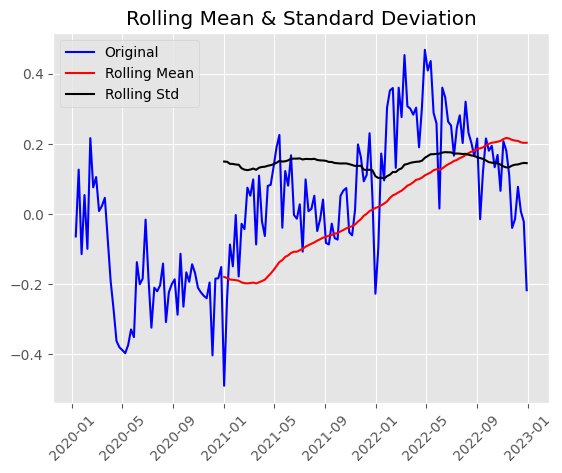

Results of Dickey-Fuller Test:
Test Statistic                  -1.770957
p-value                          0.394973
#Lags Used                       3.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [51]:
# dickey fuller test to check stationarity - 52 week window

# the below plot and data does not show stationarity (p value > 0.05, 
# as well as clear upward trend in the rolling mean)

check_stationarity(df, 52, df['bg_posts'])

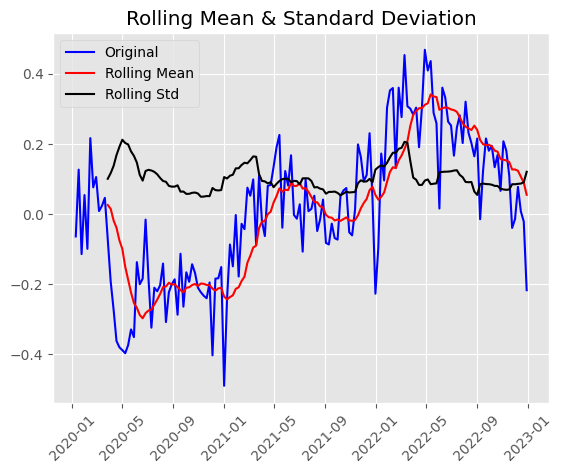

Results of Dickey-Fuller Test:
Test Statistic                  -1.770957
p-value                          0.394973
#Lags Used                       3.000000
Number of Observations Used    152.000000
Critical Value (1%)             -3.474121
Critical Value (5%)             -2.880750
Critical Value (10%)            -2.577013
dtype: float64


In [52]:
# dickey Fuller test to check stationarity - 12 week window
check_stationarity(df, 12, df['bg_posts'])

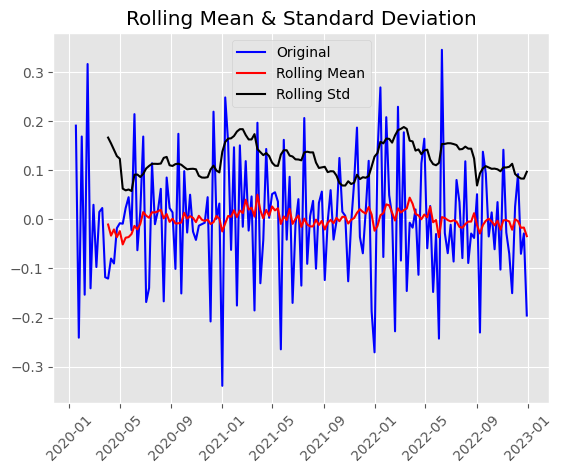

Results of Dickey-Fuller Test:
Test Statistic                -1.019408e+01
p-value                        6.212180e-18
#Lags Used                     2.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [53]:
# this looks more stationary, implies one degree of differencing needed
# p value less than 0.05
check_stationarity(df.diff(), 12, df['bg_posts'].diff().dropna())

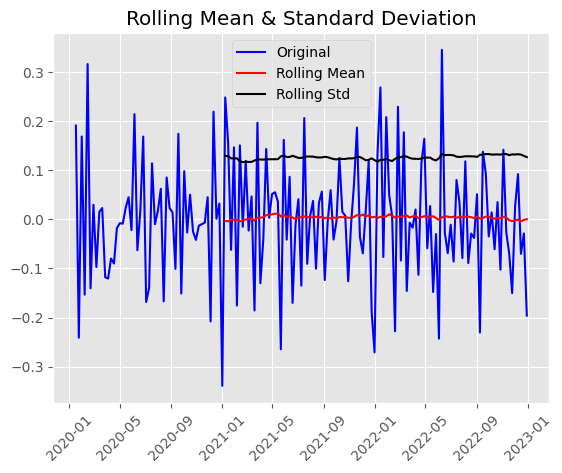

Results of Dickey-Fuller Test:
Test Statistic                -1.019408e+01
p-value                        6.212180e-18
#Lags Used                     2.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


In [54]:
# this is the most stationary, implies one degree of differencing needed
# flat rolling mean and std, differenced data, 52 week period

check_stationarity(df.diff(), 52, df['bg_posts'].diff().dropna())

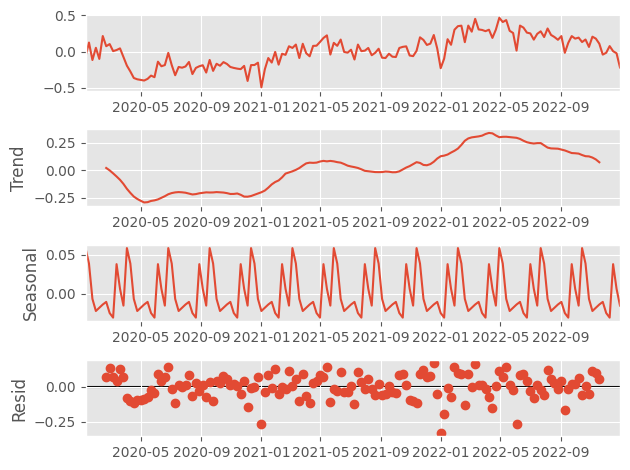

In [55]:
# with 12 period, see clear seasonal pattern and upward trend
# residuals look ok (evenly spread out)

sd = seasonal_decompose(df, period=12)
sd.plot()
plt.show()

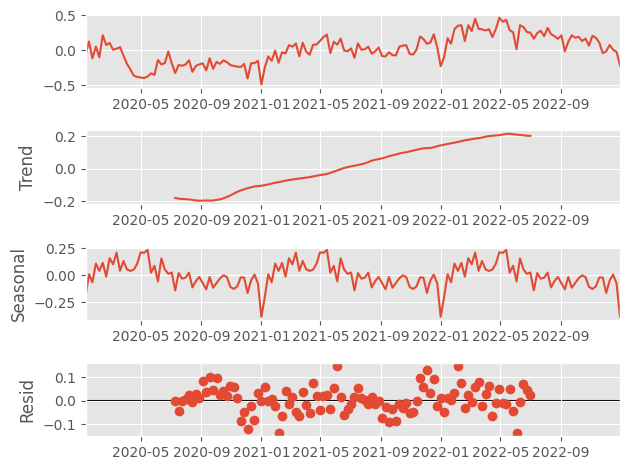

In [56]:
# upward trend even clearer with 52 week period
# 1y seasonality evident
# residuals look ok

sd = seasonal_decompose(df, period=52)
sd.plot()
plt.show()

<AxesSubplot: xlabel='date'>

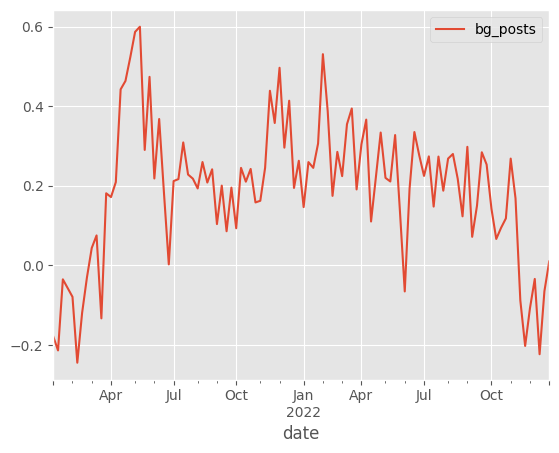

In [57]:
# visualizing 52 week shift / differencing

diff = df.dropna()
df_s_adj = diff - diff.shift(52)
df_s_adj = df_s_adj.dropna()
df_s_adj.plot()

In [58]:
# briefly looking at monthly data
df_monthly = df['bg_posts'].resample('MS').mean() # monthly frequency

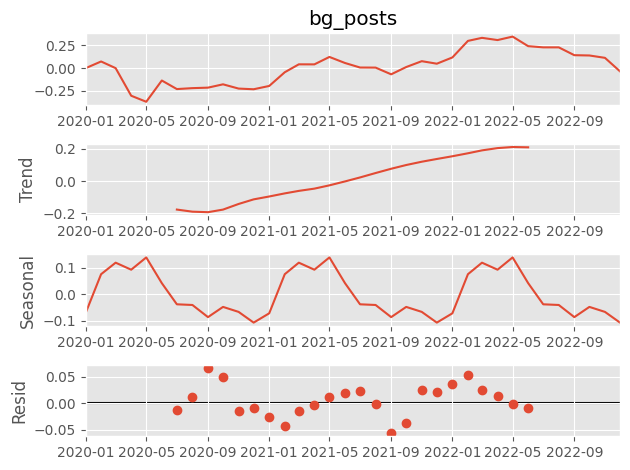

In [59]:
# smoother, but obvious seasonality and trend
# residuals not evenly spread out
# will stick with weekly data

sd = seasonal_decompose(df_monthly, period=12)
sd.plot()
plt.show()

#### Train Test Split

Splitting time series into train, test sets for model validation:

In [60]:
# weekly frequency
df = df['bg_posts'].resample('W-FRI').mean()
df = df.fillna(df.bfill())
df.head()

date
2020-01-10   -0.0646
2020-01-17    0.1260
2020-01-24   -0.1150
2020-01-31    0.0535
2020-02-07   -0.1000
Freq: W-FRI, Name: bg_posts, dtype: float64

In [61]:
# data needs to stay in chronological order so we cut off last 80% and set aside for test
cutoff = round(df.shape[0]*0.8) 
cutoff

125

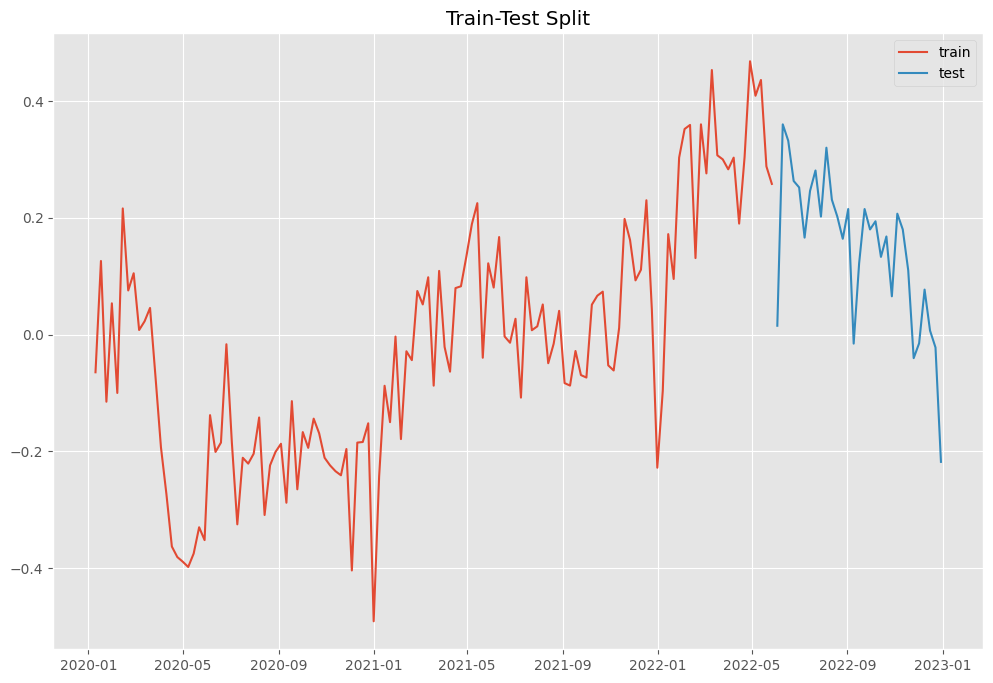

In [62]:
# train test split
train = df[:cutoff]
test = df[cutoff:]

# visualizing split
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

#### Modeling

Trying different combinations of p, d, and q on the training set to see which produces the lowest AIC.

In [63]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 52 for frequency - yearly)
pdqs = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

In [64]:
results = []

for comb in pdq:
    
    for combs in pdqs:
        
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=train,
                                            order=comb,
                                            seasonal_order=combs)
                                            #enforce_invertibility=False, 
                                            #enforce_stationarity=False)

            output = mod.fit(disp=0)
            results.append([comb, combs, output.aic])
            
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        
        except: 
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 52): AIC Calculated=-34.753156599125255


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 0) x (0, 0, 1, 52): AIC Calculated=-32.763013413471754
ARIMA (0, 0, 0) x (0, 1, 0, 52): AIC Calculated=24.173488904838592


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 0) x (0, 1, 1, 52): AIC Calculated=23.773548626435794
ARIMA (0, 0, 0) x (1, 0, 0, 52): AIC Calculated=-32.75620357074988


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 0) x (1, 0, 1, 52): AIC Calculated=-34.04860542526496
ARIMA (0, 0, 0) x (1, 1, 0, 52): AIC Calculated=23.773548667579472


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 0) x (1, 1, 1, 52): AIC Calculated=25.77354865274033
ARIMA (0, 0, 1) x (0, 0, 0, 52): AIC Calculated=-95.36397623416278


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 1) x (0, 0, 1, 52): AIC Calculated=-95.95509492939794
ARIMA (0, 0, 1) x (0, 1, 0, 52): AIC Calculated=-20.361648434846405


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 1) x (0, 1, 1, 52): AIC Calculated=-19.07650841154686
ARIMA (0, 0, 1) x (1, 0, 0, 52): AIC Calculated=-95.13114252419676


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (0, 0, 1) x (1, 0, 1, 52): AIC Calculated=-95.53249021335225
ARIMA (0, 0, 1) x (1, 1, 0, 52): AIC Calculated=-19.076508367968735


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 0, 1) x (1, 1, 1, 52): AIC Calculated=-17.076508364175233
ARIMA (0, 1, 0) x (0, 0, 0, 52): AIC Calculated=-162.9665528772562


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 0) x (0, 0, 1, 52): AIC Calculated=-171.90949377976727
ARIMA (0, 1, 0) x (0, 1, 0, 52): AIC Calculated=-81.78789074997542


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 0) x (0, 1, 1, 52): AIC Calculated=-85.91640719823631
ARIMA (0, 1, 0) x (1, 0, 0, 52): AIC Calculated=-174.65441450118007


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 0) x (1, 0, 1, 52): AIC Calculated=-174.79883125825336
ARIMA (0, 1, 0) x (1, 1, 0, 52): AIC Calculated=-85.91701479895585


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 0) x (1, 1, 1, 52): AIC Calculated=-83.91703165747074
ARIMA (0, 1, 1) x (0, 0, 0, 52): AIC Calculated=-189.21740545237301


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 1) x (0, 0, 1, 52): AIC Calculated=-197.0393264619809
ARIMA (0, 1, 1) x (0, 1, 0, 52): AIC Calculated=-94.22074964059968


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 1) x (0, 1, 1, 52): AIC Calculated=-95.5984029576189
ARIMA (0, 1, 1) x (1, 0, 0, 52): AIC Calculated=-198.67904984056145


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 1) x (1, 0, 1, 52): AIC Calculated=-197.16161004488004
ARIMA (0, 1, 1) x (1, 1, 0, 52): AIC Calculated=-95.59840242861034


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (0, 1, 1) x (1, 1, 1, 52): AIC Calculated=-93.5984032653396
ARIMA (1, 0, 0) x (0, 0, 0, 52): AIC Calculated=-172.94775972544025


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 0) x (0, 0, 1, 52): AIC Calculated=-181.09042156188028
ARIMA (1, 0, 0) x (0, 1, 0, 52): AIC Calculated=-84.41708331073815


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 0) x (0, 1, 1, 52): AIC Calculated=-86.9868332646516
ARIMA (1, 0, 0) x (1, 0, 0, 52): AIC Calculated=-182.7850525079543


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 0) x (1, 0, 1, 52): AIC Calculated=-181.4356720094806
ARIMA (1, 0, 0) x (1, 1, 0, 52): AIC Calculated=-86.97514942023055


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 0) x (1, 1, 1, 52): AIC Calculated=-84.98041446406567
ARIMA (1, 0, 1) x (0, 0, 0, 52): AIC Calculated=-190.1074521379613


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 1) x (0, 0, 1, 52): AIC Calculated=-198.27612726208133
ARIMA (1, 0, 1) x (0, 1, 0, 52): AIC Calculated=-93.78063686677307


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 1) x (0, 1, 1, 52): AIC Calculated=-94.77066101998511
ARIMA (1, 0, 1) x (1, 0, 0, 52): AIC Calculated=-199.5163137075963


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 1) x (1, 0, 1, 52): AIC Calculated=-197.68055669176283
ARIMA (1, 0, 1) x (1, 1, 0, 52): AIC Calculated=-94.72148307567181


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 0, 1) x (1, 1, 1, 52): AIC Calculated=-92.85659907775312
ARIMA (1, 1, 0) x (0, 0, 0, 52): AIC Calculated=-185.75409485607227


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 0) x (0, 0, 1, 52): AIC Calculated=-195.0314613873674
ARIMA (1, 1, 0) x (0, 1, 0, 52): AIC Calculated=-94.93338907013032


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 0) x (0, 1, 1, 52): AIC Calculated=-96.76184038431404
ARIMA (1, 1, 0) x (1, 0, 0, 52): AIC Calculated=-196.65970604216986


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 0) x (1, 0, 1, 52): AIC Calculated=-195.05784681947682
ARIMA (1, 1, 0) x (1, 1, 0, 52): AIC Calculated=-96.76184060122971


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 0) x (1, 1, 1, 52): AIC Calculated=-94.76184064567806
ARIMA (1, 1, 1) x (0, 0, 0, 52): AIC Calculated=-187.21837922425854


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 1) x (0, 0, 1, 52): AIC Calculated=-195.2387307899025
ARIMA (1, 1, 1) x (0, 1, 0, 52): AIC Calculated=-93.30625121536107


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 1) x (0, 1, 1, 52): AIC Calculated=-94.77584716376204
ARIMA (1, 1, 1) x (1, 0, 0, 52): AIC Calculated=-196.82516749330173


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 1) x (1, 0, 1, 52): AIC Calculated=-195.2338976207737
ARIMA (1, 1, 1) x (1, 1, 0, 52): AIC Calculated=-94.77586221803597


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA (1, 1, 1) x (1, 1, 1, 52): AIC Calculated=-92.77586263743228


In [65]:
results_df = pd.DataFrame(results, columns=['pdq', 'pdqs', 'aic'])
results_df.loc[results_df['aic'].idxmin()]

order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdq']
seasonal_order = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdqs']

Best performing model has order p,d,q of 1,0,1 and seasonal order p,d,q,s 1,0,0,52; AIC of -199.51

In [66]:
print(order, seasonal_order)
print(results_df.loc[results_df['aic'].idxmin()])

(1, 0, 1) (1, 0, 0, 52)
pdq         (1, 0, 1)
pdqs    (1, 0, 0, 52)
aic       -199.516314
Name: 44, dtype: object


Trying the same with a quarterly frequency:

In [67]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency - quarterly)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [68]:
results = []

for comb in pdq:
    
    for combs in pdqs:
        
        try:
            mod = sm.tsa.statespace.SARIMAX(endog=train,
                                            order=comb,
                                            seasonal_order=combs)
                                           

            output = mod.fit(disp=0)
            results.append([comb, combs, output.aic])
            
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        
        except: 
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=-34.753156599125255
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=-58.151127401348155
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=-32.589929299390185
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=-39.66978115577478
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=-62.48814589366944
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=-60.48899733701326
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=-37.9259011872866
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=-37.67695414837161
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=-95.36397623416278
ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=-104.25538817129808
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=-62.050732951965514
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=-77.97907911051838
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=-106.85898067312965
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=-105.4402295322068
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=-74.88531

/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 0) x (1, 0, 1, 12): AIC Calculated=-169.80109256789845
ARIMA (1, 0, 0) x (1, 1, 0, 12): AIC Calculated=-118.25727772646556
ARIMA (1, 0, 0) x (1, 1, 1, 12): AIC Calculated=-129.64695664648323
ARIMA (1, 0, 1) x (0, 0, 0, 12): AIC Calculated=-190.1074521379613
ARIMA (1, 0, 1) x (0, 0, 1, 12): AIC Calculated=-188.10753639737192
ARIMA (1, 0, 1) x (0, 1, 0, 12): AIC Calculated=-98.22863003448714
ARIMA (1, 0, 1) x (0, 1, 1, 12): AIC Calculated=-147.99898085682685
ARIMA (1, 0, 1) x (1, 0, 0, 12): AIC Calculated=-188.10754553280248


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA (1, 0, 1) x (1, 0, 1, 12): AIC Calculated=-186.8015915893215
ARIMA (1, 0, 1) x (1, 1, 0, 12): AIC Calculated=-131.1813521688694
ARIMA (1, 0, 1) x (1, 1, 1, 12): AIC Calculated=-146.5716112064306
ARIMA (1, 1, 0) x (0, 0, 0, 12): AIC Calculated=-185.75409485607227
ARIMA (1, 1, 0) x (0, 0, 1, 12): AIC Calculated=-183.75501305851392
ARIMA (1, 1, 0) x (0, 1, 0, 12): AIC Calculated=-89.65244386944957
ARIMA (1, 1, 0) x (0, 1, 1, 12): AIC Calculated=-145.8401335167473
ARIMA (1, 1, 0) x (1, 0, 0, 12): AIC Calculated=-183.755167298752
ARIMA (1, 1, 0) x (1, 0, 1, 12): AIC Calculated=-181.75737843259026
ARIMA (1, 1, 0) x (1, 1, 0, 12): AIC Calculated=-127.81336713856228
ARIMA (1, 1, 0) x (1, 1, 1, 12): AIC Calculated=-144.89376775123017
ARIMA (1, 1, 1) x (0, 0, 0, 12): AIC Calculated=-187.21837922425854
ARIMA (1, 1, 1) x (0, 0, 1, 12): AIC Calculated=-185.24070558793562
ARIMA (1, 1, 1) x (0, 1, 0, 12): AIC Calculated=-92.09869848274724
ARIMA (1, 1, 1) x (0, 1, 1, 12): AIC Calculated=-144.567

/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [69]:
results_df = pd.DataFrame(results, columns=['pdq', 'pdqs', 'aic'])
results_df.loc[results_df['aic'].idxmin()]

order_weekly = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdq']
seasonal_order_weekly = results_df.iloc[results_df.loc[results_df['aic'].idxmin()].name]['pdqs']

print(order_weekly, seasonal_order_weekly)
print(results_df.loc[results_df['aic'].idxmin()])

(1, 0, 1) (0, 0, 0, 12)
pdq         (1, 0, 1)
pdqs    (0, 0, 0, 12)
aic       -190.107452
Name: 40, dtype: object


Running best model (52 week seasonality):

In [70]:
sari_mod = sm.tsa.statespace.SARIMAX(train,
                                     order=order,
                                     seasonal_order=seasonal_order).fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.82302D-01    |proj g|=  2.22227D-01

At iterate    5    f= -8.29213D-01    |proj g|=  3.84287D-01

At iterate   10    f= -8.30064D-01    |proj g|=  6.29660D-04

At iterate   15    f= -8.30065D-01    |proj g|=  5.65783D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     21      1     0     0   1.416D-05  -8.301D-01
  F = -0.83006525483038529     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [71]:
# Fit the model and print results
print(sari_mod.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            bg_posts   No. Observations:                  125
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 52)   Log Likelihood                 103.758
Date:                             Fri, 10 Feb 2023   AIC                           -199.516
Time:                                     09:41:20   BIC                           -188.203
Sample:                                 01-10-2020   HQIC                          -194.920
                                      - 05-27-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9560      0.030     31.768      0.000       0.897       1.015
ma.L1         -0.4367      

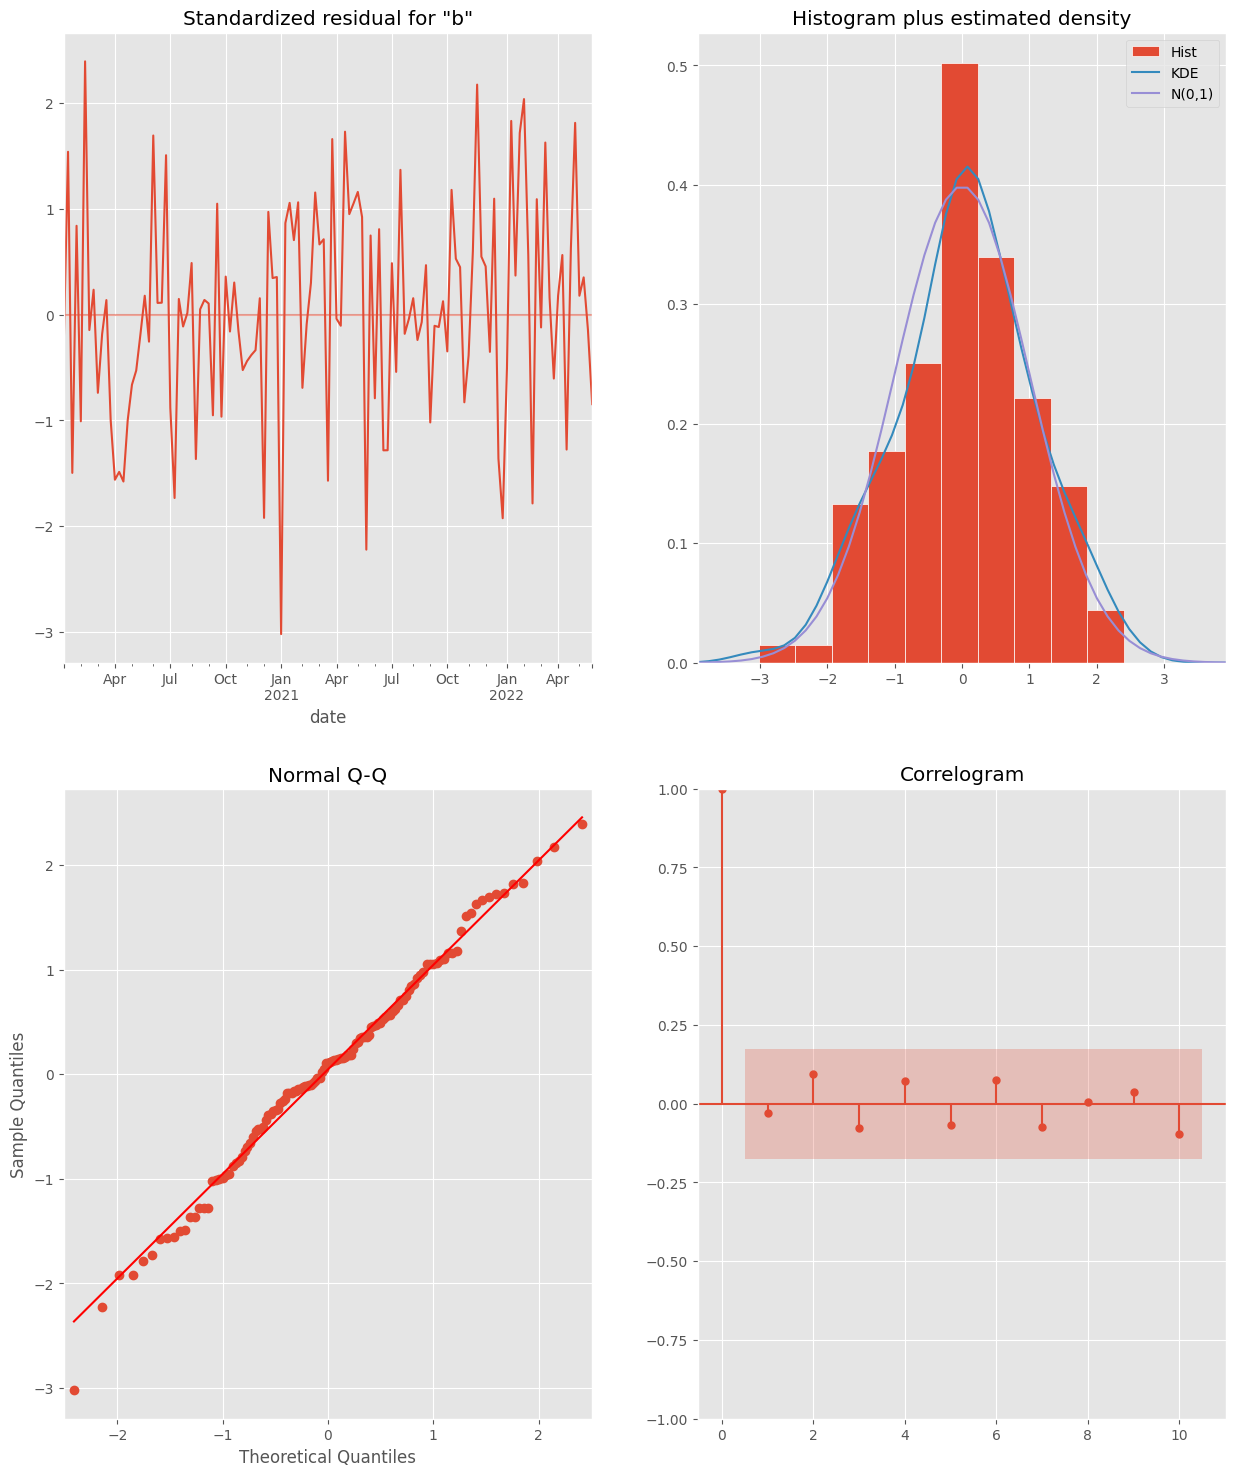

In [72]:
sari_mod.plot_diagnostics(figsize=(15, 18))
plt.savefig('images/timeseries_diagnostics.png')

plt.show()

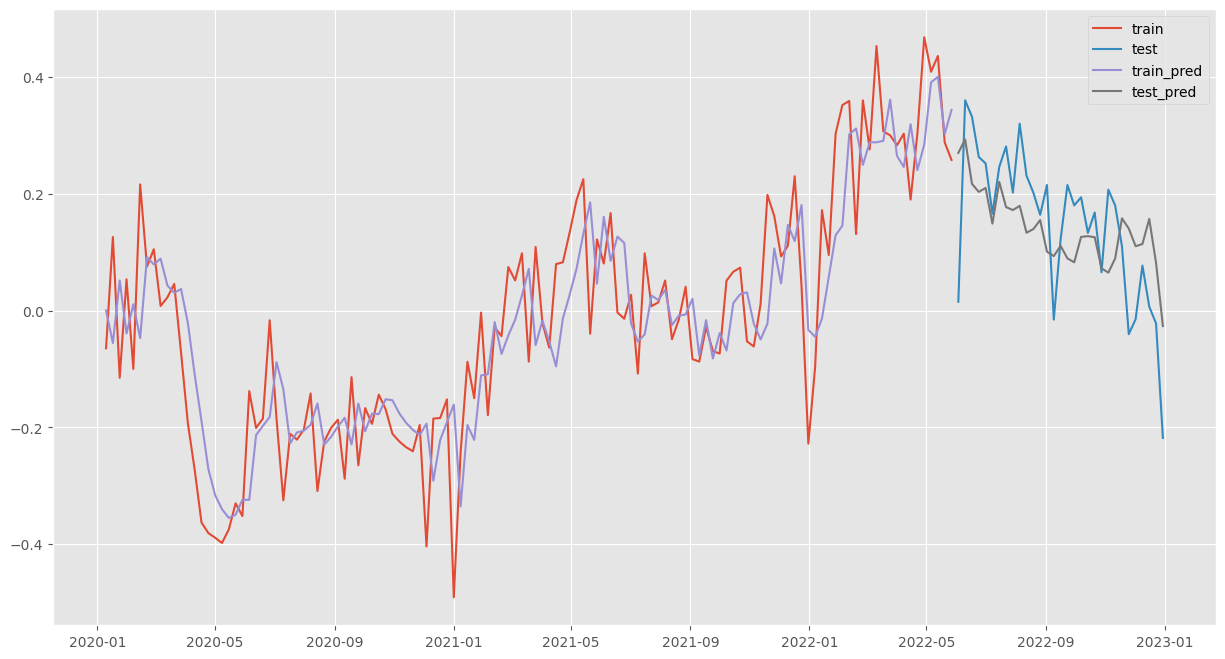

In [73]:
y_hat_train = sari_mod.predict(typ='levels')
y_hat_test = sari_mod.predict(start=test.index[0], end=test.index[-1], 
                              typ='levels', dynamic=True)

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(train, label='train')
ax.plot(test, label='test') # valid
ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test, label='test_pred')

plt.legend()

plt.savefig('assets/timeseries_validation.png');

In [74]:
# Train / test mean-squared errors:
print("MSE, train: ", str(np.sqrt(mean_squared_error(train, y_hat_train))))

error = np.sqrt(mean_squared_error(test, y_hat_test))
print("MSE, test: ", str(error))

MSE, train:  0.10524469105447441
MSE, test:  0.10490398624905958


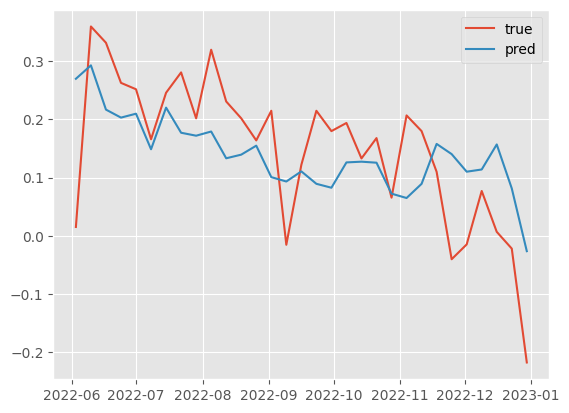

In [75]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='true')
ax.plot(y_hat_test, label='pred')

plt.legend();

#### Forecast

In [76]:
# running model on full series
sari_mod_final = sm.tsa.statespace.SARIMAX(df,
                                           order=order,
                                           seasonal_order=seasonal_order).fit()

forecast = sari_mod_final.forecast(steps=52, dynamic=True)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.03934D-01    |proj g|=  2.38856D-01

At iterate    5    f= -8.42229D-01    |proj g|=  3.94021D-01

At iterate   10    f= -8.43112D-01    |proj g|=  1.57516D-03

At iterate   15    f= -8.43154D-01    |proj g|=  2.55200D-02

At iterate   20    f= -8.43239D-01    |proj g|=  5.60717D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     29      1     0     0   4.435D-05  -8.432D-01
  F = -0.84323960500069595     

CONVERG

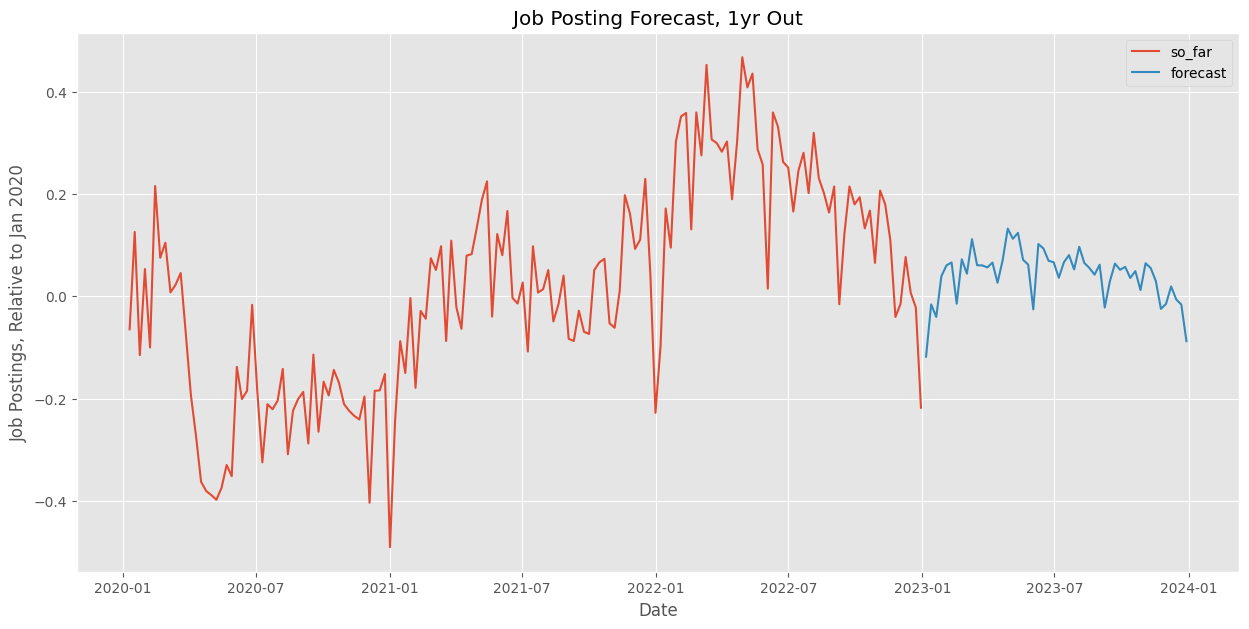

In [77]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Job Posting Forecast, 1yr Out')
ax.set_xlabel('Date')
ax.set_ylabel('Job Postings, Relative to Jan 2020')

plt.legend()

plt.savefig('assets/job_forecast.png');

In [78]:
# storing preds in dataframe
forecast_df = pd.DataFrame(forecast).reset_index()
forecast_df.columns = ['date', 'prediction']
forecast_df.to_csv('data/jobs_forecast.csv')

In [79]:
forecast_df.head()

,date,prediction
0,2023-01-06,-0.117993
1,2023-01-13,-0.015724
2,2023-01-20,-0.040327
3,2023-01-27,0.039365
4,2023-02-03,0.060616


<AxesSubplot: >

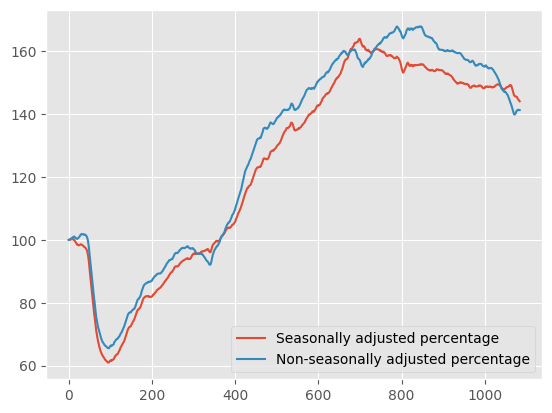

In [80]:
# indeed data - plot for comparision
# smoother than Lightcast data, but same trend

indeed_jobs[['Date', 'Seasonally adjusted percentage', 'Non-seasonally adjusted percentage']].plot()

# Supervised Models

In the following classification models, we will use <b>recall</b> as our primary scoring metric. That is because we want our model to identify as many companies that had multiple rounds of layoffs as possible, even if it means sometimes falsely identifying a company that had one round as having multiple rounds. We'd rather err on the side of caution and assume a company had multiple rounds if any of the data suggests so. An employee would rather be pleasantly surprised than assume they were safe in their job.

Our secondary target will be the <b>ROC-AUC score</b>. This tells us how well the model distinguishes between classes. The higher the ROC-AUC score, the better the model is at predicting class 0 (one round of layoffs) as 0 and class 1 (multiple layoffs) as 1.

### Data Prep

In [81]:
# inspecting original layoffs data from layoffs.fyi
layoffs_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2210 entries, 0 to 2209
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              2210 non-null   object 
 1   location             2210 non-null   object 
 2   industry             2209 non-null   object 
 3   total_laid_off       1518 non-null   float64
 4   percentage_laid_off  1486 non-null   float64
 5   date                 2210 non-null   object 
 6   stage                2204 non-null   object 
 7   country              2210 non-null   object 
 8   funds_raised         2210 non-null   float64
dtypes: float64(3), object(6)
memory usage: 155.5+ KB


In [82]:
layoffs_raw.isnull().sum()

company                  0
location                 0
industry                 1
total_laid_off         692
percentage_laid_off    724
date                     0
stage                    6
country                  0
funds_raised             0
dtype: int64

In [83]:
# getting rid of nans (very few for this subset)
layoffs_raw = layoffs_raw.dropna(subset=['industry', 'stage']).reset_index(drop=True)

In [84]:
# # converting to numeric type
# layoffs_raw['funds_raised'] = pd.to_numeric(layoffs_raw['funds_raised'], 
#                                             errors='coerce')

In [85]:
# # replacing missing value of funds raised with median
# layoffs_raw['funds_raised'].fillna(layoffs_raw['funds_raised'].median(), 
#                                    inplace=True)

In [86]:
# converting to datetime, adding column for year
layoffs_raw['date'] = pd.to_datetime(layoffs_raw['date'])
layoffs_raw['year'] = [day.year for day in layoffs_raw['date']]

In [87]:
# checking for duplicates
layoffs_raw[layoffs_raw.duplicated()]

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,year
1344,cazoo,London,Transportation,750.0,0.15,2022-06-07,Post-IPO,United Kingdom,2000.0,2022


In [88]:
# after some research, it appears there were indeed two rounds of layoffs
# for Cazoo
layoffs_raw[layoffs_raw.company=='cazoo']

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,year
193,cazoo,London,Transportation,NaN,NaN,2023-01-18,Post-IPO,United Kingdom,2000.0,2023
1343,cazoo,London,Transportation,750.0,0.15,2022-06-07,Post-IPO,United Kingdom,2000.0,2022
1344,cazoo,London,Transportation,750.0,0.15,2022-06-07,Post-IPO,United Kingdom,2000.0,2022


In [89]:
layoffs_raw[layoffs_raw.company=='science 37'] # science 37 did have multiple layoffs
# source: https://endpts.com/two-decentralized-trials-startups-prove-theyre-not-immune-to-broader-wave-of-biotech-layoffs/

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,year
578,science 37,Los Angeles,Healthcare,90.0,NaN,2022-11-14,Post-IPO,United States,347.0,2022


In [90]:
# second round of layoffs were on 9/8/2022
# source: https://sifted.eu/articles/cazoo-layoffs-european-union/ 

layoffs_raw.iloc[1245]['date'] = '2022-09-08' # adding correct value
layoffs_raw.iloc[481]['date'] = '2022-08-24'

/var/folders/wl/4cw_k4nj07d773kdv1fw53tc0000gn/T/ipykernel_53118/3996955332.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoffs_raw.iloc[1245]['date'] = '2022-09-08' # adding correct value
/var/folders/wl/4cw_k4nj07d773kdv1fw53tc0000gn/T/ipykernel_53118/3996955332.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layoffs_raw.iloc[481]['date'] = '2022-08-24'


In [91]:
# layoffs_sorted = layoffs_raw[['company', 'funds_raised', 'date']].sort_values(by='date')
# # funds raised in first round of layoffs and
# #year of first layoffs

# ff = layoffs_sorted.drop_duplicates(subset=['company'], keep='first')
# ff['year_fr'] = [day.year for day in ff.date]
# ff.columns=['company', 'funds_raised_fr', 'date_fr', 'year_fr']

# ff[ff.company=='uber']

In [92]:
layoffs_raw[layoffs_raw.company=='uber']

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised,year
857,uber,Vilnius,Transportation,60.0,NaN,2022-09-07,Post-IPO,Lithuania,24700.0,2022
1680,uber,Amsterdam,Transportation,225.0,0.25,2020-06-12,Post-IPO,Netherlands,24700.0,2020
1712,uber,Bengaluru,Transportation,600.0,0.23,2020-05-26,Post-IPO,India,24700.0,2020
1731,uber,SF Bay Area,Transportation,3000.0,0.13,2020-05-18,Post-IPO,United States,24700.0,2020
1776,uber,SF Bay Area,Transportation,3700.0,0.14,2020-05-06,Post-IPO,United States,24700.0,2020


In [93]:
# list of companies that had more than one round of layoffs
mult_layoffs = list(layoffs_raw.company.value_counts()[layoffs_raw.company.value_counts() > 1].index)

In [94]:
len(mult_layoffs)

322

In [95]:
# only including relevant info, also only want one company per row
data_classification = layoffs_raw.drop(['total_laid_off', 'percentage_laid_off', 
                                        'date', 'year'], axis=1)

# adding target column: whether company had multiple rounds of layoffs
data_classification['multiple'] = [True if co in mult_layoffs else False 
                                   for co in data_classification.company]
data_classification.tail()

,company,location,industry,stage,country,funds_raised,multiple
2198,service,Los Angeles,Travel,Seed,United States,5.1,True
2199,hopskipdrive,Los Angeles,Transportation,Unknown,United States,45.0,True
2200,panda squad,SF Bay Area,Consumer,Seed,United States,1.0,False
2201,tamara mellon,Los Angeles,Retail,Series C,United States,90.0,False
2202,easypost,Salt Lake City,Logistics,Series A,United States,12.0,True


In [96]:
# dealing with multiple rows representing same company

In [97]:
len(data_classification)

2203

In [98]:
data_classification[data_classification.company.duplicated()]

,company,location,industry,stage,country,funds_raised,multiple
261,oyster,Charlotte,HR,Series C,United States,224.0,True
385,swiggy,Bengaluru,Food,Unknown,India,3600.0,True
389,chrono24,Karlsruhe,Retail,Series C,Germany,205.0,True
417,intel,SF Bay Area,Hardware,Post-IPO,United States,12.0,True
436,thinkific,Vancouver,Education,Post-IPO,Canada,22.0,True
...,...,...,...,...,...,...,...
2188,bounce,Bengaluru,Transportation,Series D,India,214.0,True
2196,inspirato,Denver,Travel,Series C,United States,79.0,True
2198,service,Los Angeles,Travel,Seed,United States,5.1,True
2199,hopskipdrive,Los Angeles,Transportation,Unknown,United States,45.0,True


In [99]:
# grouped = data_classification.groupby(by=['company', 'location', 'industry', 
#                                           'stage', 'country']).sum().reset_index()

In [100]:
# len(grouped)

In [101]:
# grouped[grouped.company.duplicated()] # same as pivot - checks out

In [102]:
len(data_classification)

2203

In [103]:
#layoffs_raw[layoffs_raw.date>'22-01-2023'].to_csv('extra_cos.csv')

In [104]:
# inspecting
layoffs_sorted[layoffs_sorted.company=='uber']

,company,location,industry,total_laid_off,percentage_laid_off,date,stage,country,funds_raised
1783,uber,SF Bay Area,Transportation,3700.0,0.14,2020-05-06,Post-IPO,United States,24700.0
1738,uber,SF Bay Area,Transportation,3000.0,0.13,2020-05-18,Post-IPO,United States,24700.0
1719,uber,Bengaluru,Transportation,600.0,0.23,2020-05-26,Post-IPO,India,24700.0
1687,uber,Amsterdam,Transportation,225.0,0.25,2020-06-12,Post-IPO,Netherlands,24700.0
862,uber,Vilnius,Transportation,60.0,NaN,2022-09-07,Post-IPO,Lithuania,24700.0


In [105]:
# date, year, and funds raised from first round of layoffs
ff.head() # can reset index if needed

,company,funds_raised_fr,date_fr,year_fr
2209,easypost,12.0,2020-03-11,2020
2208,tamara mellon,90.0,2020-03-12,2020
2206,hopskipdrive,45.0,2020-03-13,2020
2207,panda squad,1.0,2020-03-13,2020
2204,help.com,6.0,2020-03-16,2020


In [106]:
# total funds raised per company from layoffs
funds = data_classification[['company', 'funds_raised']].groupby(by='company').sum().reset_index()
display(funds.head())

,company,funds_raised
0,#paid,21.0
1,&open,35.0
2,100 thieves,240.0
3,10x genomics,242.0
4,1stdibs,253.0


In [107]:
# data_classification['multiple'] = [True if co in mult_layoffs else False 
#                                    for co in data_classification.company]

In [108]:
# if company has more than one round of layoffs, assigning 1 otherwise 
# assigning 0 to multiple column

layoffs_occurrance = data_classification[['company', 'multiple']].groupby(by='company').sum().reset_index()
layoffs_occurrance['multiple'] = [1 if val > 0 else 0 for val in layoffs_occurrance['multiple']]
layoffs_occurrance.head()

,company,multiple
0,#paid,0
1,&open,0
2,100 thieves,1
3,10x genomics,0
4,1stdibs,0


In [109]:
# prepping dataset to drop Unknown stage if duplicated
df1 = pd.pivot_table(data_classification, 
                     index=['company', 'location', 'stage', 'industry', 'country'], 
                     values='funds_raised', aggfunc=np.sum).reset_index()

df1 = df1.sort_values(by='stage').reset_index(drop=True)
df1.head()

,company,location,stage,industry,country,funds_raised
0,zywave,Milwaukee,Acquired,Finance,United States,151.0
1,tuft & needle,Phoenix,Acquired,Retail,United States,0.0
2,tufin,Boston,Acquired,Security,United States,21.0
3,bittitan,Seattle,Acquired,Data,United States,46.0
4,bittorrent,SF Bay Area,Acquired,Infrastructure,United States,151.0


In [110]:
len(df1[df1.duplicated(subset='company')])

125

In [111]:
len(df1)

1900

In [112]:
# duplicated companies
dup = df1[df1.duplicated(subset='company')]

In [113]:
# checking that index location is same in dup and df1
dup[dup.company=='ebanx']

,company,location,stage,industry,country,funds_raised
1829,ebanx,Curitiba,Unknown,Finance,Brazil,30.0


In [114]:
df1[df1.company=='ebanx']

,company,location,stage,industry,country,funds_raised
911,ebanx,Curitiba,Series B,Finance,Brazil,460.0
1829,ebanx,Curitiba,Unknown,Finance,Brazil,30.0


In [115]:
# dropping duplicated where stage is Unknown
df1 = df1.drop(index=list(dup[dup['stage']=='Unknown'].index)).reset_index(drop=True)

In [116]:
len(df1)

1874

In [117]:
# dropping all duplicates, resetting funds_raised to sum of funds
# raised during all layoffs per company, retagging target 

df_final = df1.drop_duplicates(subset='company', keep='last').reset_index(drop=True)
df_final['funds_raised'] = [float(funds['funds_raised'][funds['company']==co]) 
                            for co in df_final['company']]
df_final['multiple'] = [int(layoffs_occurrance['multiple'][layoffs_occurrance['company']==co]) 
                        for co in df_final['company']]
len(df_final) # makes sense: 1830 - 120 = 1710

1775

In [118]:
sum(df_final.company.duplicated())

0

In [119]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1775 entries, 0 to 1774
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       1775 non-null   object 
 1   location      1775 non-null   object 
 2   stage         1775 non-null   object 
 3   industry      1775 non-null   object 
 4   country       1775 non-null   object 
 5   funds_raised  1775 non-null   float64
 6   multiple      1775 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 97.2+ KB


In [120]:
# adding in data on first round of funding
df_final = df_final.merge(ff, how='left', on='company')
df_final

,company,location,stage,industry,country,funds_raised,multiple,funds_raised_fr,date_fr,year_fr
0,zywave,Milwaukee,Acquired,Finance,United States,151.0,0,151.0,2022-12-07,2022
1,tuft & needle,Phoenix,Acquired,Retail,United States,0.0,0,0.0,2020-03-19,2020
2,tufin,Boston,Acquired,Security,United States,21.0,0,21.0,2022-08-21,2022
3,bittitan,Seattle,Acquired,Data,United States,46.0,0,46.0,2021-11-18,2021
4,bittorrent,SF Bay Area,Acquired,Infrastructure,United States,151.0,0,151.0,2023-01-20,2023
...,...,...,...,...,...,...,...,...,...,...
1770,gokada,Lagos,Unknown,Transportation,Nigeria,24.0,1,12.0,2022-11-14,2022
1771,lighthouse labs,Toronto,Unknown,Education,Canada,151.0,0,151.0,2020-04-09,2020
1772,textio,Seattle,Unknown,Recruiting,United States,41.0,0,41.0,2020-03-27,2020
1773,digital surge,Brisbane,Unknown,Crypto,Australia,151.0,0,151.0,2022-12-09,2022


In [121]:
df_final.to_csv('df_final.csv')

In [122]:
#### CRUNCHBASE ####

In [123]:
# # merge df_final with crunchbase data

# df_final2 = df_final.merge(df_cb_subset, on='company', how='inner')
# df_final2.head()

In [124]:
# df_final2.info()

In [125]:
# sum(df_final2.company.duplicated())

In [126]:
#######

In [127]:
df_classification_cb.head()

,company,date,industry,country,Headquarters Location,Headquarters Regions,Operating Status,total_laid_off,percentage_laid_off,stage,...,Estimated Revenue Range,Number of Funding Rounds,Trend Score (30 Days),Number of Employees,Number of Acquisitions,year_fr,funds_raised_fr,Founded Date,founded_year,rev_est
0,equitybee,2023-02-08,Finance,United States,"Palo Alto, California, United States","San Francisco Bay Area, Silicon Valley, West C...",Active,24.0,0.250000,Series B,...,n/a,4.0,-0.5,1-10,0.0,2022,85.0,2018-01-01,2018.0,3.000000e+07
1,godaddy,2023-02-08,Marketing,United States,"Scottsdale, Arizona, United States","Greater Phoenix Area, Western US",Active,600.0,0.080000,Post-IPO,...,$1B to $10B,3.0,-0.4,5001-10000,29.0,2020,151.0,1997-01-01,1997.0,5.000000e+09
2,salesloft,2023-02-07,Sales,United States,"Atlanta, Georgia, United States","Greater Atlanta Area, East Coast, Southern US",Active,100.0,0.100000,Acquired,...,$50M to $100M,8.0,-1.1,501-1000,3.0,2020,145.0,2011-01-01,2011.0,7.500000e+07
3,loggi,2023-02-06,Logistics,Brazil,"São Paulo, Sao Paulo, Brazil",Latin America,Active,300.0,0.070000,Series F,...,n/a,8.0,0.4,1001-5000,1.0,2022,507.0,2013-06-20,2013.0,3.000000e+07
4,clari,2023-02-06,Sales,United States,"Sunnyvale, California, United States","San Francisco Bay Area, Silicon Valley, West C...",Active,20.0,0.026667,Series F,...,$10M to $50M,8.0,5.3,501-1000,1.0,2022,496.0,2013-01-01,2013.0,3.000000e+07


In [128]:
print(len(df_classification_cb), len(df_classification_cb[df_classification_cb.company.duplicated()]))
# 356 duplicated companies

1477 378


In [129]:
# dropping columns we do not plan on using in the model
df_class_final = df_classification_cb.drop(['Headquarters Regions', 'Founded Date'], axis=1)

In [130]:
# excluding duplicated rows
df_class_final = df_class_final[~df_class_final.duplicated()]

In [131]:
df_class_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1476
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   company                                 1459 non-null   object 
 1   date                                    1459 non-null   object 
 2   industry                                1459 non-null   object 
 3   country                                 1459 non-null   object 
 4   Headquarters Location                   1459 non-null   object 
 5   Operating Status                        1459 non-null   object 
 6   total_laid_off                          1459 non-null   float64
 7   percentage_laid_off                     1459 non-null   float64
 8   stage                                   1457 non-null   object 
 9   Industries                              1459 non-null   object 
 10  Industry Groups                         1459 non-null   obje

In [132]:
# dropping columns we do not plan on using in the model
df2 = df_class_final.drop(['Estimated Revenue Range', 
                           'total_laid_off', 
                           'percentage_laid_off'], axis=1)

In [133]:
sum(df2.duplicated())

5

In [134]:
# dropping duplicates once again
df2 = df2[~df2.duplicated()]

In [135]:
# dropping rows with nas 
df2 = df2.dropna(subset='stage').reset_index(drop=True)

In [136]:
# sorting from oldest to newest
df2 = df2.sort_values(by='date').reset_index(drop=True)

# dropping duplicated where stage is Unknown
dup = df2[df2.duplicated(subset='company')]
df2 = df2.drop(index=list(dup[dup['stage']=='Unknown'].index)).reset_index(drop=True)

# keeping rows with most recent record
df2 = df2.drop_duplicates(subset='company', keep='last').reset_index(drop=True)

In [137]:
df2[df2.company.duplicated()] # no duplicates

,company,date,industry,country,Headquarters Location,Operating Status,stage,Industries,Industry Groups,Total Funding Amount Currency (in USD),Number of Funding Rounds,Trend Score (30 Days),Number of Employees,Number of Acquisitions,year_fr,funds_raised_fr,founded_year,rev_est


In [138]:
df2['multiple'] = [1 if co in mult_layoffs else 0 for co in df2.company]

In [139]:
df2.multiple.value_counts(normalize=True)

0    0.762078
1    0.237922
Name: multiple, dtype: float64

In [140]:
df2.to_csv('df2.csv')

### Classification with Layoffs.fyi data

#### Train Test Split

In [141]:
df_final = pd.read_csv('df_final.csv', index_col=0)

In [142]:
X = df_final.drop(['multiple', 'company', 'funds_raised', 'date_fr'], axis=1)
y = df_final['multiple']

In [143]:
y.value_counts(normalize=True) # fairly imbalanced, will need to address

0    0.818592
1    0.181408
Name: multiple, dtype: float64

In [144]:
X.shape

(1775, 6)

In [145]:
sum(df_final.company.duplicated())

0

In [146]:
X.head()

,location,stage,industry,country,funds_raised_fr,year_fr
0,Milwaukee,Acquired,Finance,United States,151.0,2022
1,Phoenix,Acquired,Retail,United States,0.0,2020
2,Boston,Acquired,Security,United States,21.0,2022
3,Seattle,Acquired,Data,United States,46.0,2021
4,SF Bay Area,Acquired,Infrastructure,United States,151.0,2023


In [147]:
print(len(set(X['location'])))
print(len(set(X['country'])))

179
55


In [148]:
# train test split & preprocess
cat_columns = ['industry', 'stage'] #'location'

X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
y_train, y_test = train_test_preprocess(X, y, cat_columns)

In [149]:
X_train_processed.shape

(1331, 47)

#### Baseline

In [150]:
# baseline
baseline_model = LogisticRegression(random_state=42) 
baseline_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [151]:
# baseline is no better than random guessing, & very low recall
y_hat_train = baseline_model.predict(X_train_scaled)
y_hat_test = baseline_model.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test) 

Training Recall:  0.10548523206751055
Test Recall:  0.07058823529411765


Training F1:  0.18248175182481752
Test F1:  0.12631578947368421


ROC AUC Train:  0.5472581553390569
ROC AUC Test:  0.5472581553390569


Training Accuracy:  0.8317054845980466
Testing Accuracy:  0.8130630630630631


In [152]:
#### SMOTE to deal with class imbalance

In [153]:
print(y_train.value_counts())

sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)
X_train_res_scaled, y_train_res_scaled = sm.fit_resample(X_train_scaled, y_train)

print(pd.Series(y_train_res).value_counts()) 

0    1094
1     237
Name: multiple, dtype: int64
0    1094
1    1094
Name: multiple, dtype: int64


#### Model Tuning

In this section I will run various models and test out a number of parameters to find a best-performing model.

In [154]:
dtc = DecisionTreeClassifier(random_state=42) #, class_weight='balanced')

dtc.fit(X_train_res, y_train_res)
y_hat_train = dtc.predict(X_train_res)
y_hat_test = dtc.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9890310786106032
Test Recall:  0.23529411764705882


Training F1:  0.9944852941176471
Test F1:  0.27777777777777773


ROC AUC Train:  0.9945155393053016
ROC AUC Test:  0.9945155393053016


Training Accuracy:  0.9945155393053017
Testing Accuracy:  0.7657657657657657


In [155]:
pipe = Pipeline([('classifier' , DecisionTreeClassifier(random_state=42))])

param_grid = [{
    
    'classifier' : [DecisionTreeClassifier(random_state=42)],
    'classifier__criterion': ['gini', 'entropy', 'log_loss'],
    'classifier__max_depth': [None, 1, 5, 10],
    'classifier__min_samples_split': [2, 5, 15]
    #'classifier__class_weight': [None, 'balanced'] # only need w/o SMOTE
}]

dtc_grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='f1')

dtc_best = dtc_grid.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [156]:
y_hat_train = dtc_best.predict(X_train_res)
y_hat_test = dtc_best.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8391224862888482
Test Recall:  0.23529411764705882


Training F1:  0.8809980806142034
Test F1:  0.29411764705882354


ROC AUC Train:  0.8866544789762341
ROC AUC Test:  0.8866544789762341


Training Accuracy:  0.886654478976234
Testing Accuracy:  0.7837837837837838


In [157]:
xgb = XGBClassifier(random_state=42)#, scale_pos_weight=1.5)
xgb.fit(X_train_res, y_train_res)
y_hat_train = xgb.predict(X_train_res)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9296160877513712
Test Recall:  0.2


Training F1:  0.9607935758148324
Test F1:  0.272


ROC AUC Train:  0.9620658135283364
ROC AUC Test:  0.9620658135283364


Training Accuracy:  0.9620658135283364
Testing Accuracy:  0.795045045045045


In [158]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=7)
xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  1.0
Test Recall:  0.4


Training F1:  0.8330404217926186
Test F1:  0.3541666666666667


ROC AUC Train:  0.9565813528336381
ROC AUC Test:  0.9565813528336381


Training Accuracy:  0.9286250939143501
Testing Accuracy:  0.7207207207207207


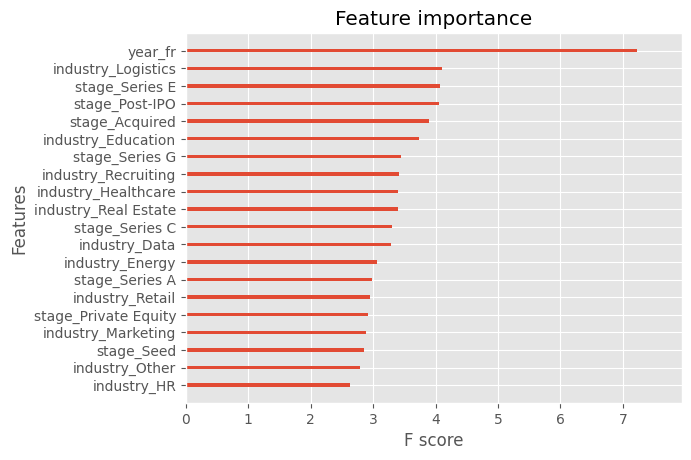

In [159]:
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)
plt.show()

In [160]:
# random forest model with imbalanced data
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train_processed, y_train)
y_hat_train = rf.predict(X_train_processed)
y_hat_test = rf.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9915611814345991
Test Recall:  0.16470588235294117


Training F1:  0.9710743801652892
Test F1:  0.22764227642276422


ROC AUC Train:  0.9902961300226012
ROC AUC Test:  0.9902961300226012


Training Accuracy:  0.9894815927873779
Testing Accuracy:  0.786036036036036


In [161]:
# random forest model with smote-balanced data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_hat_train = rf.predict(X_train_res)
y_hat_test = rf.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.9899451553930531
Test Recall:  0.21176470588235294


Training F1:  0.9944903581267218
Test F1:  0.2727272727272727


ROC AUC Train:  0.9945155393053018
ROC AUC Test:  0.9945155393053018


Training Accuracy:  0.9945155393053017
Testing Accuracy:  0.7837837837837838


In [162]:
# Logistic Regression with balanced class weight - big improvement
lr = LogisticRegression(random_state=42, class_weight='balanced') 

lr.fit(X_train_scaled, y_train)

y_hat_train = lr.predict(X_train_scaled)
y_hat_test = lr.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.6751054852320675
Test Recall:  0.6588235294117647


Training F1:  0.4306864064602961
Test F1:  0.4307692307692308


ROC AUC Train:  0.6794174592522312
ROC AUC Test:  0.6794174592522312


Training Accuracy:  0.6821938392186326
Testing Accuracy:  0.6666666666666666


In [163]:
# logistic regression model with SMOTE balanced data - best so far
lr2 = LogisticRegression(random_state=42)
lr2.fit(X_train_res_scaled, y_train_res_scaled)

y_hat_train = lr2.predict(X_train_res_scaled)
y_hat_test = lr2.predict(X_test_scaled)

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7074954296160878
Test Recall:  0.6235294117647059


Training F1:  0.701722574796011
Test F1:  0.4257028112449799


ROC AUC Train:  0.6992687385740403
ROC AUC Test:  0.6992687385740403


Training Accuracy:  0.6992687385740403
Testing Accuracy:  0.6779279279279279


In [164]:
# param tuning logistic regression model
pipe = Pipeline([('classifier' , LogisticRegression(random_state=42))])

param_grid = [{
    
    'classifier' : [LogisticRegression(random_state=42)],
    'classifier__C': [0, 0.5, 1, 2, 1e12],
    'classifier__solver': ['newton-cg', 'liblinear', 'lbfgs', 'saga'],
    'classifier__penalty': ['l1', 'l2', None],
   
}]
    
lr_grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='recall')

lr_best = lr_grid.fit(X_train_res_scaled, y_train_res_scaled)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will 

/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached 

/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please a

/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reache

This is just about our best model. It correctly identifies 71% of companies that had more than one round of layoffs (recall).

In [165]:
y_hat_train = lr_best.predict(X_train_res_scaled) # or scaled
y_hat_test = lr_best.predict(X_test_scaled) # or scaled

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7102376599634369
Test Recall:  0.6352941176470588


Training F1:  0.69968482665466
Test F1:  0.43027888446215135


ROC AUC Train:  0.6951553930530165
ROC AUC Test:  0.6951553930530165


Training Accuracy:  0.6951553930530164
Testing Accuracy:  0.6779279279279279


In [166]:
lr_best.best_params_

{'classifier': LogisticRegression(C=2, random_state=42, solver='newton-cg'),
 'classifier__C': 2,
 'classifier__penalty': 'l2',
 'classifier__solver': 'newton-cg'}

In [167]:
best_lr = LogisticRegression(random_state=42, C=0.5, penalty='l1', solver='liblinear')
best_lr.fit(X_train_res_scaled, y_train_res_scaled)

LogisticRegression(C=0.5, penalty='l1', random_state=42, solver='liblinear')

In [168]:
## Top coefficients by magnitude

coef_df = pd.DataFrame(best_lr.coef_, columns=X_train_res_scaled.columns).transpose()

coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

coef_df.sort_values(by='coef_abs', ascending=False)[:10]

,coef,coef_abs
stage_Seed,-1.639710,1.639710
industry_Real Estate,1.425862,1.425862
industry_Recruiting,-1.403936,1.403936
industry_Crypto,1.192929,1.192929
industry_HR,-1.083649,1.083649
stage_Acquired,-1.060391,1.060391
stage_Series A,-1.017724,1.017724
industry_Data,-1.000309,1.000309
stage_Series F,0.992739,0.992739
industry_Education,0.979320,0.979320


In [169]:

# largest coefficients by magintude in the logistic regression model
feat_importance = coef_df.sort_values(by='coef_abs', ascending=False)[:15]

y=np.array(feat_importance['coef'])
color=np.array(['rgb(255,255,255)']*y.shape[0])
color[y<0]='rgb(204,204, 205)'
color[y>=0]='rgb(130, 0, 0)'

data=[dict(type='bar', y=y, marker=dict(color=color.tolist()))]

fig = px.bar(feat_importance['coef'], color=data[0]['marker']['color'])
fig.update_layout(showlegend=False)
fig.show()

In [170]:
# largest coefficients by magnitude in the logistic regression model
fig = px.bar(feat_importance['coef'])
fig.update_layout(showlegend=False)
fig.show()

[Text(0, 0.5, 'One'), Text(0, 1.5, 'Multiple')]

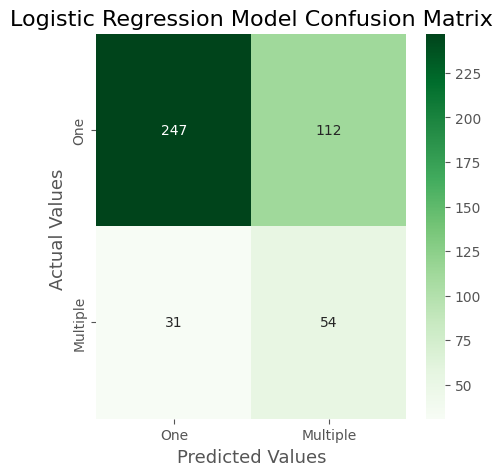

In [171]:
# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_hat_test)
fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

ax.set_title('Logistic Regression Model Confusion Matrix', fontsize=16);
ax.set_xlabel('Predicted Values',fontsize=13)
ax.set_ylabel('Actual Values ', fontsize=13);

ax.xaxis.set_ticklabels(['One','Multiple'])
ax.yaxis.set_ticklabels(['One','Multiple'])

In [172]:
### PREDICTION EXAMPLE ###
#example_company = ['Austin', 'Stage B', 'Real Estate', 'United States', 50.0]

In [173]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=6, max_depth=2, 
                    min_child_weight=40, subsample=0.5) # with full data / smote

xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7637130801687764
Test Recall:  0.6235294117647059


Training F1:  0.41849710982658955
Test F1:  0.3745583038869258


ROC AUC Train:  0.6775603792068745
ROC AUC Test:  0.6775603792068745


Training Accuracy:  0.6220886551465064
Testing Accuracy:  0.6013513513513513


###  Classification with Crunchbase Data

Building a model with the Crunchbase data & layoffs dataset to see if that improves performance.

#### Train Test Split

In [174]:
df2 = pd.read_csv('df2.csv', index_col=0)

In [175]:
X = df2.drop(['multiple', 'company', 'date'], axis=1)
y = df2['multiple']

In [176]:
X.head()

,industry,country,Headquarters Location,Operating Status,stage,Industries,Industry Groups,Total Funding Amount Currency (in USD),Number of Funding Rounds,Trend Score (30 Days),Number of Employees,Number of Acquisitions,year_fr,funds_raised_fr,founded_year,rev_est
0,Retail,United States,"New York, New York, United States",Active,Series C,"E-Commerce, Fashion, Lifestyle, Retail, Shoes,...","Clothing and Apparel, Commerce and Shopping, C...",90492915.0,3.0,1.0,1-10,0.0,2020,90.0,2010.0,5000000.0
1,Transportation,United States,"Los Angeles, California, United States",Active,Unknown,"Child Care, Children, Information Technology, ...","Community and Lifestyle, Health Care, Informat...",123799999.0,12.0,2.1,101-250,0.0,2020,45.0,2014.0,500000.0
2,Consumer,United States,"Bucharest, Bucuresti, Romania",Active,Seed,"Advertising, Event Management, Small and Mediu...","Advertising, Events, Media and Entertainment, ...",199500000.0,6.0,-0.5,1-10,0.0,2020,1.0,2016.0,500000.0
3,Support,United States,"Austin, Texas, United States",Active,Seed,"Customer Service, Enterprise Software, SaaS","Other, Professional Services, Software",6000000.0,1.0,0.6,11-50,0.0,2020,6.0,2021.0,5000000.0
4,Marketing,United States,"Boulder, Colorado, United States",Active,Seed,"Advertising, Advertising Platforms","Advertising, Sales and Marketing",4618000.0,5.0,0.6,11-50,0.0,2020,4.0,2012.0,5000000.0


In [224]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1097 entries, 0 to 1096
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   industry                  1097 non-null   object 
 1   country                   1097 non-null   object 
 2   Headquarters Location     1097 non-null   object 
 3   Operating Status          1097 non-null   object 
 4   stage                     1097 non-null   object 
 5   Industries                1097 non-null   object 
 6   Industry Groups           1097 non-null   object 
 7   Number of Funding Rounds  1097 non-null   float64
 8   Trend Score (30 Days)     1097 non-null   float64
 9   Number of Employees       1097 non-null   object 
 10  Number of Acquisitions    1097 non-null   float64
 11  year_fr                   1097 non-null   int64  
 12  funds_raised_fr           1097 non-null   float64
 13  founded_year              1097 non-null   float64
 14  rev_est 

/var/folders/wl/4cw_k4nj07d773kdv1fw53tc0000gn/T/ipykernel_53118/2271803833.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Text(0.5, 1.0, 'Heatmap of Correlation Between Attributes (Including Target)')

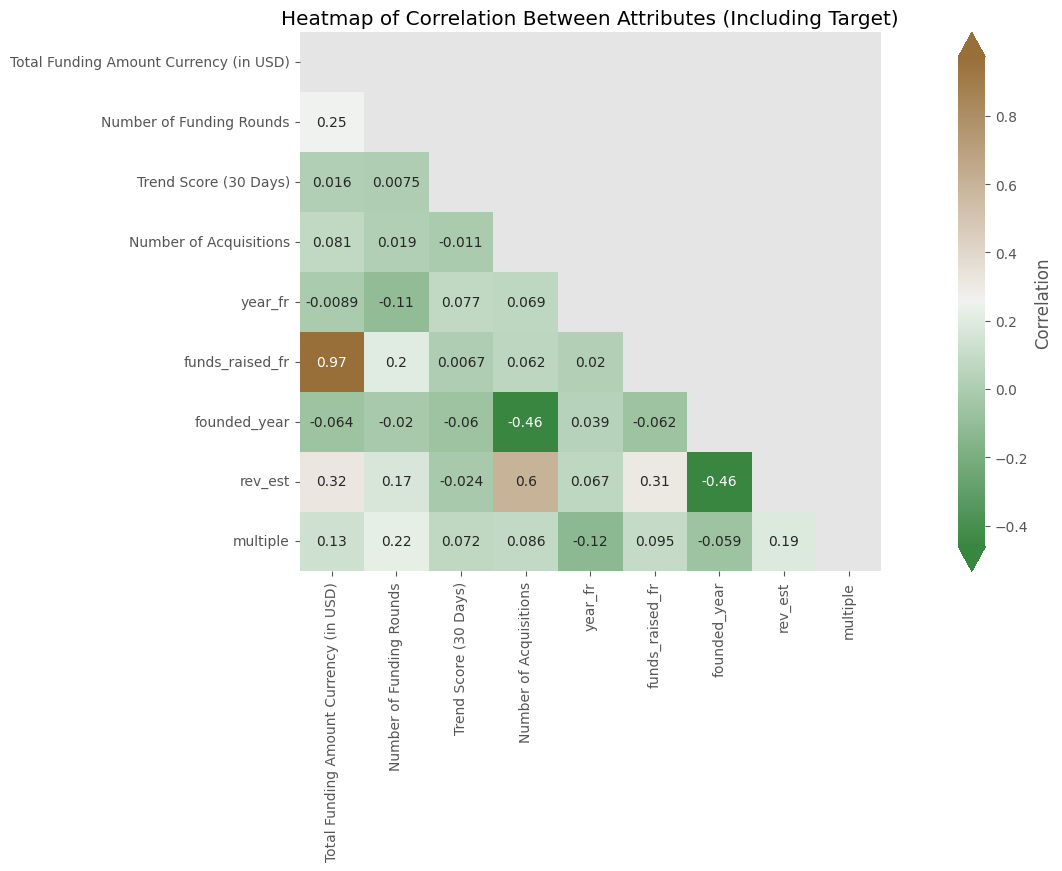

In [177]:
# checking correlations - will remove total funding amount due to high correlation with funds_fr
heatmap_data = pd.concat([X, y], axis=1)
h_corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(10, 7))
mask = np.triu(np.ones_like(h_corr, dtype=bool))
cmap = sns.diverging_palette(130, 50, as_cmap=True)
cbar_kws = {'label': 'Correlation', 'orientation': 'vertical', 
            'pad': .1, 'extend': 'both'}
sns.heatmap(data=h_corr, mask=mask, ax=ax, annot=True, cbar_kws=cbar_kws, cmap=cmap)
ax.set_title('Heatmap of Correlation Between Attributes (Including Target)')

In [178]:
X = X.drop(['Total Funding Amount Currency (in USD)'], axis=1)

In [179]:
# train test split & preprocess
cat_columns = ['industry', 'stage', 'Number of Employees', 
               'Operating Status', 'country']

X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
y_train, y_test = train_test_preprocess(X, y, cat_columns)

In [180]:
print(y_train.value_counts())

sm = SMOTE(random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)
X_train_res_scaled, y_train_res_scaled = sm.fit_resample(X_train_scaled, y_train)

print(pd.Series(y_train_res).value_counts()) 

0    627
1    195
Name: multiple, dtype: int64
1    627
0    627
Name: multiple, dtype: int64


#### Logistic Regression

After running several logistic regression classifiers, none of them could achieve a recall above around 70%. We will try a new type of classification model next - XG Boost. Given our information from the classification models in the previous section, we know XG Boost is a good option.

In [181]:
lr2 = LogisticRegression(random_state=42, solver='liblinear')
lr2.fit(X_train_res_scaled, y_train_res_scaled)

y_hat_train = lr2.predict(X_train_res_scaled)
y_hat_test = lr2.predict(X_test_scaled)

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.784688995215311
Test Recall:  0.6060606060606061


Training F1:  0.7494287890327496
Test F1:  0.4848484848484848


ROC AUC Train:  0.7376395534290271
ROC AUC Test:  0.7376395534290271


Training Accuracy:  0.7376395534290271
Testing Accuracy:  0.6909090909090909


In [182]:
## Top coefficients - this list makes a lot of sense

coef_df = pd.DataFrame(lr2.coef_, columns=X_train_res_scaled.columns).transpose()
#coef_df.to_csv('coef_logreg.csv')

coef_df.columns=['coef']
coef_df['coef_abs'] = abs(coef_df['coef'])

coef_df.sort_values(by='coef_abs', ascending=False)[:20]

,coef,coef_abs
industry_Recruiting,-1.940703,1.940703
industry_Marketing,-1.571915,1.571915
country_Indonesia,-1.369607,1.369607
stage_Series G,-1.366449,1.366449
country_Chile,1.354770,1.354770
industry_Crypto,1.341694,1.341694
Number of Employees_11-50,-1.329860,1.329860
country_Israel,1.315640,1.315640
stage_Series H,1.292224,1.292224
industry_Aerospace,1.231713,1.231713


In [183]:
# param tuning logistic regression model
pipe = Pipeline([('classifier' , LogisticRegression(random_state=42))])

param_grid = [{
    
    'classifier' : [LogisticRegression(random_state=42)],
    'classifier__C': [0, 0.5, 1, 2, 1e12],
    'classifier__solver': ['newton-cg', 'liblinear', 'lbfgs', 'saga'],
    'classifier__penalty': ['l1', 'l2', None],
   
}]

lr_grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='recall')

lr_best = lr_grid.fit(X_train_res_scaled, y_train_res_scaled)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number o

/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached 

/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ig

In [184]:
lr_best.best_params_

{'classifier': LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear'),
 'classifier__C': 2,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [185]:
# Not much improvement in scoring, so will try some other combinations of parameters
y_hat_train = lr_best.predict(X_train_res_scaled) # or scaled
y_hat_test = lr_best.predict(X_test_scaled) # or scaled

print_scores(y_train_res_scaled, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7862838915470495
Test Recall:  0.6060606060606061


Training F1:  0.7549770290964778
Test F1:  0.4848484848484848


ROC AUC Train:  0.7448165869218502
ROC AUC Test:  0.7448165869218502


Training Accuracy:  0.74481658692185
Testing Accuracy:  0.6909090909090909


In [186]:
lr3 = LogisticRegression(random_state=42, class_weight='balanced')
lr3.fit(X_train_scaled, y_train)

y_hat_train = lr2.predict(X_train_scaled)
y_hat_test = lr2.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.6974358974358974
Test Recall:  0.6060606060606061


Training F1:  0.518095238095238
Test F1:  0.4848484848484848


ROC AUC Train:  0.6940130045393204
ROC AUC Test:  0.6940130045393204


Training Accuracy:  0.6922141119221411
Testing Accuracy:  0.6909090909090909


In [187]:
lr3 = LogisticRegression(random_state=42, class_weight='balanced')
lr3.fit(X_train_scaled, y_train)

y_hat_train = lr3.predict(X_train_scaled)
y_hat_test = lr3.predict(X_test_scaled)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7282051282051282
Test Recall:  0.6515151515151515


Training F1:  0.5419847328244275
Test F1:  0.5029239766081871


ROC AUC Train:  0.7149797570850202
ROC AUC Test:  0.7149797570850202


Training Accuracy:  0.708029197080292
Testing Accuracy:  0.6909090909090909


In [188]:
lr4 = LogisticRegression(random_state=42, penalty='l2', C=1e12)
lr4.fit(X_train_res_scaled, y_train_res)

y_hat_train = lr3.predict(X_train_res_scaled)
y_hat_test = lr3.predict(X_test_scaled)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.7511961722488039
Test Recall:  0.6515151515151515


Training F1:  0.7330739299610896
Test F1:  0.5029239766081871


ROC AUC Train:  0.726475279106858
ROC AUC Test:  0.726475279106858


Training Accuracy:  0.726475279106858
Testing Accuracy:  0.6909090909090909


/Users/natalyadoris/opt/anaconda3/envs/proj-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



#### XG Boost Classifier / Final Model Evaluation

In [189]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=2, 
                    min_child_weight=30, subsample=0.5)
xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8564102564102564
Test Recall:  0.6515151515151515


Training F1:  0.5475409836065575
Test F1:  0.45026178010471196


ROC AUC Train:  0.7304379830695621
ROC AUC Test:  0.7304379830695621


Training Accuracy:  0.6642335766423357
Testing Accuracy:  0.6181818181818182


In [190]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=2, 
                     min_child_weight=10, subsample=0.5) # with full data

xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8769230769230769
Test Recall:  0.6212121212121212


Training F1:  0.6107142857142858
Test F1:  0.431578947368421


ROC AUC Train:  0.78375659428291
ROC AUC Test:  0.78375659428291


Training Accuracy:  0.7347931873479319
Testing Accuracy:  0.6072727272727273


In [191]:
xgb = XGBClassifier(random_state=42, max_depth=4, min_child_weight=25, 
                    subsample=0.5) # country / industry
xgb.fit(X_train_res, y_train_res)
y_hat_train = xgb.predict(X_train_res)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8118022328548644
Test Recall:  0.3939393939393939


Training F1:  0.8283157038242475
Test F1:  0.4262295081967213


ROC AUC Train:  0.8317384370015949
ROC AUC Test:  0.8317384370015949


Training Accuracy:  0.8317384370015949
Testing Accuracy:  0.7454545454545455


In [238]:
#X_train_processed = X_train_processed.reindex(sorted(X_train_processed.columns), axis=1)
#X_test_processed = X_test_processed.reindex(sorted(X_test_processed.columns), axis=1)

xgb = XGBClassifier(random_state=42, scale_pos_weight=4, max_depth=2, 
                     min_child_weight=50, subsample=0.5) # with full data / smote

xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.764102564102564
Test Recall:  0.7121212121212122


Training F1:  0.5182608695652174
Test F1:  0.5136612021857924


ROC AUC Train:  0.6978407557354925
ROC AUC Test:  0.6978407557354925


Training Accuracy:  0.6630170316301703
Testing Accuracy:  0.6763636363636364


In [193]:
# plot_importance(xgb, max_num_features=20, importance_type='gain', 
#                 show_values=False)
# plt.show()

In [194]:
# # plot confusion matrix
# conf_matrix = confusion_matrix(y_test, y_hat_test)
# fig, ax = plt.subplots(figsize=(5,5))

# ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

# ax.set_title('Final Model Confusion Matrix', fontsize=16);
# ax.set_xlabel('Predicted Values',fontsize=13)
# ax.set_ylabel('Actual Values ', fontsize=13);

# ax.xaxis.set_ticklabels(['One','Multiple'])
# ax.yaxis.set_ticklabels(['One','Multiple'])

In [195]:
### BEST MODEL ###

This model performs the best as far as recall and ROC AUC score. This will be the final model.

In [239]:
xgb = XGBClassifier(random_state=42, scale_pos_weight=5, max_depth=4, 
                    min_child_weight=40, subsample=0.5) # with full data / smote

xgb.fit(X_train_processed, y_train)
y_hat_train = xgb.predict(X_train_processed)
y_hat_test = xgb.predict(X_test_processed)

print_scores(y_train, y_hat_train, y_test, y_hat_test)

Training Recall:  0.8307692307692308
Test Recall:  0.7272727272727273


Training F1:  0.5192307692307692
Test F1:  0.4897959183673469


ROC AUC Train:  0.7024659550975342
ROC AUC Test:  0.7024659550975342


Training Accuracy:  0.635036496350365
Testing Accuracy:  0.6363636363636364


In [197]:
# # save final model for use in dashboard
filename = 'final_classification_model.pkl'
pickle.dump(xgb, open(filename, 'wb'))

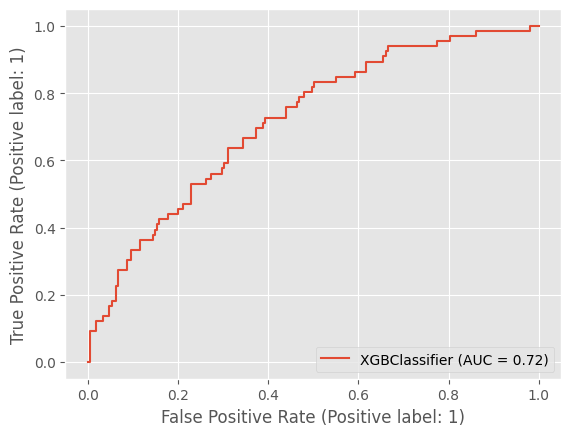

In [198]:
# plot ROC AUC
RocCurveDisplay.from_estimator(xgb, X_test_processed, y_test)

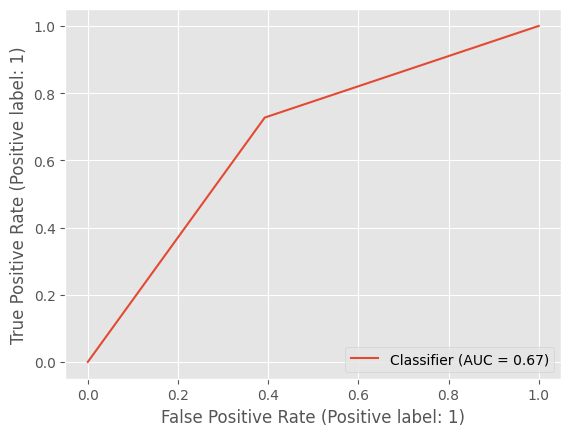

In [199]:
# plot ROC AUC
RocCurveDisplay.from_predictions(y_test, y_hat_test)
plt.savefig('assets/ROC_AUC_curve.png')

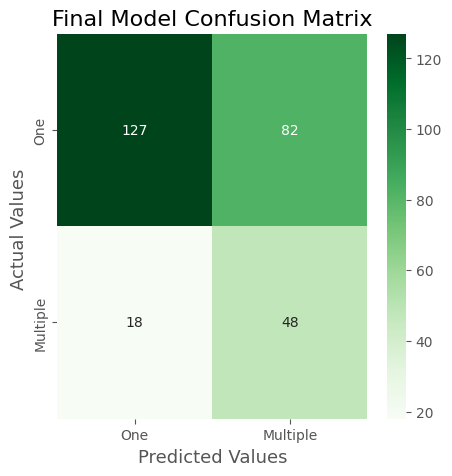

In [200]:
# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_hat_test)
fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='d')

ax.set_title('Final Model Confusion Matrix', fontsize=16);
ax.set_xlabel('Predicted Values',fontsize=13)
ax.set_ylabel('Actual Values ', fontsize=13);

ax.xaxis.set_ticklabels(['One','Multiple'])
ax.yaxis.set_ticklabels(['One','Multiple'])

##
plt.savefig('assets/final_confusion_matrix.png')

Number of employees is the most important feature. Specifically, whether a company falls into the category of company size of 501-1000.

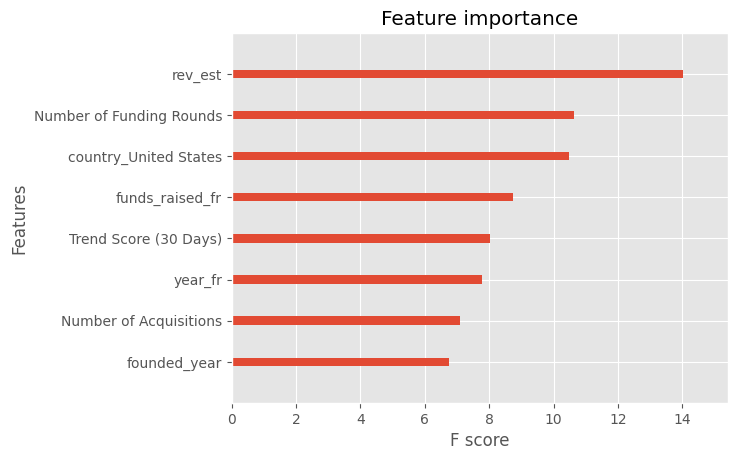

In [201]:
plot_importance(xgb, max_num_features=20, importance_type='gain', 
                show_values=False)

plt.show()

# Conclusion and Next Steps

- THERE IS HOPE. Job postings should remain stable for the next year, meaning there are opportunities for laid off employees
- Larger companies tend to see more rounds of layoffs: be proactive if you are an employee at one of these firms

Next Steps:
- Gather additional company data to feed into classification model
- Gather data describing the specific roles laid off, salary, & types of jobs posted to match laid off employees with job postings that may fit their background

# APPENDIX

Please disregard the below code. It may be used in future versions of the notebook for revisions.

In [202]:
# When you are modeling for prediction, you are asking the question "How well can I use X (independent variables or features) to predict Y (dependent or target or outcome variable)?" Thus, in this case, you are less concerned about how and which features impact Y as opposed to how you can efficiently use them to predict Y.

# When modeling for prediction, you typically use all available features (and most likely engineer new features) because you are trying to accurately predict Y, at all costs. As a result, you are less concerned about the coefficients of these features and instead focus on the overall accuracy of the model.

# target = layoffs 
# inputs:
# - sector
# - econ data
# - job postings by sector?
# - business openings?
# - some measure of revenues

# Regression for each sector?

# Classification - given one layoff, prob of second?

In [203]:
# xgb = XGBClassifier(random_state=42, max_depth=3,  
#                     min_child_weight=30, subsample=0.5, alpha=0.5)


# xgb.fit(X_train_res, y_train_res)
# y_hat_train = xgb.predict(X_train_res)
# y_hat_test = xgb.predict(X_test_processed)

# print_scores(y_train_res, y_hat_train, y_test, y_hat_test)

In [204]:
# plot_importance(xgb, max_num_features=20, importance_type='gain', 
#                 show_values=False)
# plt.show()

In [205]:
# from prophet import Prophet

In [206]:
# df_prophet = job_postings_national[['date', 'bg_posts']]
# df_prophet = df_prophet.rename(columns={'date': 'ds', 'bg_posts': 'y'})

In [207]:
# Model = Prophet(interval_width=0.95)
# Model.fit(df_prophet)

In [208]:
# future_dates = Model.make_future_dataframe(periods=52, freq='W-SAT')
# future_dates.tail()

In [209]:
# # Predict the values for future dates and take the head of forecast
# forecast = Model.predict(future_dates)
# forecast.head()

In [210]:
# # Subset above mentioned columns and view the tail 
# forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [211]:
# # Use Prophet's plot method to plot the predictions
# Model.plot(forecast, uncertainty=True)
# plt.show()

In [212]:
# # Plot model components 
# Model.plot_components(forecast)
# plt.show()

In [213]:
### MODEL PREDICTION IN DASHBOARD

In [214]:
# # save final model for use in dashboard
# filename = 'final_classification_model.pkl'
# pickle.dump(xgb, open(filename, 'wb'))

# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test_processed, y_test)

# print(result)

In [215]:
# pred_df = pd.DataFrame(columns=X_train_processed.columns)
# pred_df

# X.columns

# example_co = ['Aerospace', 'United Kingdom', 10000000, 3, 0.5, '1000', 2, 2021, 320, 2018, 50000000]

# def prep_pred(example_co):
#     example_df = pd.DataFrame(columns=X.columns[-11:])
#     #example_co = ['Aerospace', 'United Kingdom', 10000000, 3, 0.5, 2, 2021, 320, 2018, 50000000]
#     ex = example_co
#     ex[0] = 'industry_'+ example_co[0]
#     ex[1] = 'country_'+ example_co[1]
#     ex[5] = 'Number of Employees_'+ example_co[5]
#     example_df.rename(columns={'Industries': ex[0], 
#                                'Industry Groups': ex[1], 
#                                'Number of Employees': ex[5]}, inplace=True)
    
#     ex[0] = 1
#     ex[1] = 1
#     ex[5] = 1
   
#     example_df.loc[0] = ex
    
#     for col in X_train_processed:
#         if col not in example_df:
#             #print("Adding missing feature {}".format(col))
#             example_df[col] = 0
            
#     example_df = example_df.reindex(sorted(example_df.columns), axis=1)

#     return example_df

In [216]:
# example_co = ['Marketing', 'United Kingdom', 10000000, 3, 0.5, '501-1000', 2, 2021, 10, 2018, 50000000]
# test = prep_pred(example_co)
# #test = test.reindex(sorted(test.columns), axis=1)
# loaded_model.predict(test)

In [217]:
# for col_name in test.columns:
    
#     if col_name not in X_train_processed.columns:
#         print('Error! ', col_name)

In [218]:
### MORE XGBOOST

In [219]:
# # witn industry rather than industry group
# xgb = XGBClassifier(random_state=42, scale_pos_weight=4, max_depth=2, 
#                     min_child_weight=50, subsample=0.5)


# xgb.fit(X_train_processed, y_train)
# y_hat_train = xgb.predict(X_train_processed)
# y_hat_test = xgb.predict(X_test_processed)

# print_scores(y_train, y_hat_train, y_test, y_hat_test)

In [220]:
# pred_df

In [221]:
# plot_importance(xgb, max_num_features=20, importance_type='gain', 
#                 show_values=False)
# plt.show()

In [222]:
## uncomment to add more specific features (location and industry group)

# # train test split & preprocess
# cat_columns = ['industry', 'stage', 'Number of Employees', 
#                'Operating Status', 'country'] #'location' #industry groups

# X_train_processed, X_train_scaled, X_test_processed, X_test_scaled, \
# y_train, y_test = train_test_preprocess(X, y, cat_columns)

In [223]:
# print(y_train.value_counts())

# sm = SMOTE(random_state = 42)
# X_train_res, y_train_res = sm.fit_resample(X_train_processed, y_train)
# X_train_res_scaled, y_train_res_scaled = sm.fit_resample(X_train_scaled, y_train)

# print(pd.Series(y_train_res).value_counts()) 